### **Loading Used Libriries**

In [1]:
import numpy as np # linear algebra
import numpy.matlib
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
import random
import os ## handle files
import torch ## PyTorch
import torch.nn as nn ## Neural networks package
from torch import optim ## optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import models ## package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
import torchvision.transforms as transforms ## for data augmentation
from sklearn.model_selection import train_test_split ## to split datasets
import seaborn as sns ## data plot
from sklearn.metrics import confusion_matrix ## plot the confusion matrix


# Setting the random seed for reproducibility
seed = 77
np.random.seed(seed) ## for numpy
torch.manual_seed(seed) ## for PyTorch
torch.cuda.manual_seed(seed)
random.seed(24) ## for random module on python


# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available.")
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## use gpu if its available

GPU is available.
Number of GPUs available: 1
GPU 0: Tesla P100-PCIE-16GB


#### **Using Weights and Biases to Track the Models' Development**

In [2]:
!pip install wandb -qU ## install wandb

# Log in to your W&B account
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **1 - EDA of HAM10000 Dataset**

##### **1.1 - Loading Data**

In [4]:
## Path to data
HAM1000_path = '/kaggle/input/skin-cancer-mnist-ham10000/'

## to map the class acronym to its real name, according to the paper of the dataset
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

## collecting image paths
all_image_path = glob(os.path.join(HAM1000_path, '*', '*.jpg'))

## imageid_path_dict will map each image ID (the file name without the extension) to its full file path.
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}


df_original = pd.read_csv(os.path.join(HAM1000_path, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

## class names
classes = df_original['dx'].unique()

df_original.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
3  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
4  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

##### **1.2 - Data Distribution**

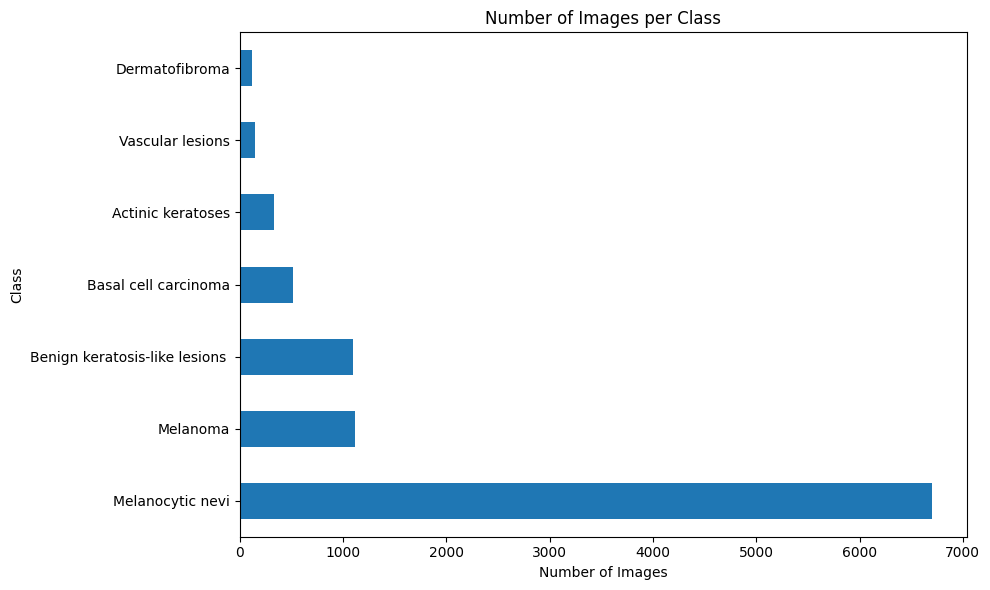

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64


In [5]:
# Count the number of images in each class
class_counts = df_original['cell_type'].value_counts()

# Plot a histogram
plt.figure(figsize=(10, 6))
class_counts.plot(kind='barh')

# Add title and labels
plt.title('Number of Images per Class')
plt.ylabel('Class')
plt.xlabel('Number of Images')

# Display the plot
plt.tight_layout()
plt.show()


print(class_counts)

#### We have a clearly prevalence of the Melanocytic nevi class but, more generally, it is possible to notice an imbalance of the classes samples.

##### **1.3 Samples Example**

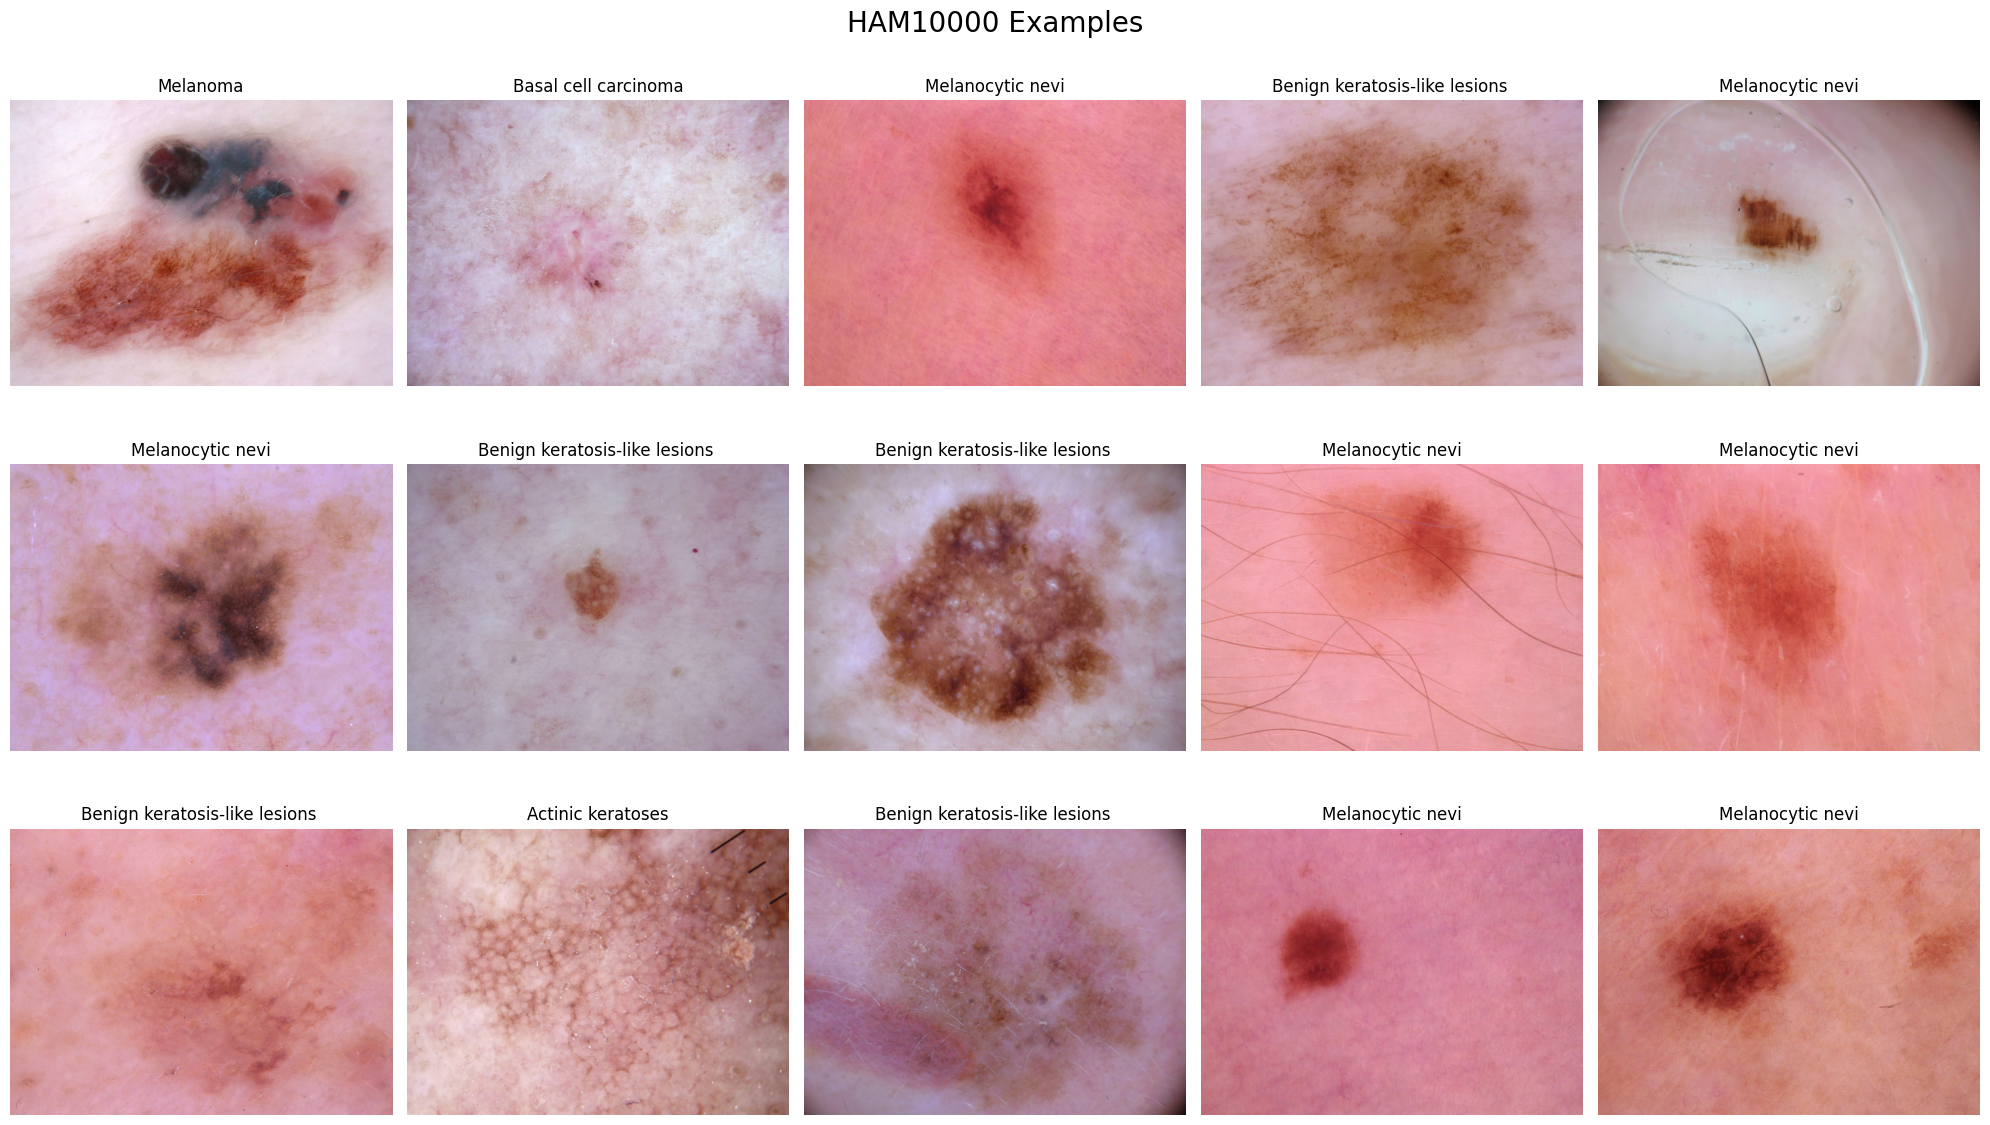

CPU times: user 3.68 s, sys: 214 ms, total: 3.9 s
Wall time: 3.71 s


In [5]:
%%time
## Showing some examples of the data

# Randomly select 15 rows from the dataframe
sample_df = df_original.sample(n=15)

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = row['path']
    cell_type = row['cell_type']
    
    # Open the image
    img = Image.open(img_path)
    
    # Display the image on the axis
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')  # Hide the axes ticks

# Add a main title for the whole plot
plt.suptitle('HAM10000 Examples', fontsize=20)
# Adjust the layout
plt.tight_layout()
plt.show()


### **2 - Data Pre-processing**

##### **2.1 - Useful Functions**

In [6]:
## Plots the Train/Val curves (Losses and Main Metric) 
def plot_history(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist, model_name):
    epochs = range(1, len(train_loss_hist) + 1)
    
    # Plotting the loss history
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_hist, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss_hist, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_hist, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, 'ro-', label='Validation Accuracy')
    plt.title(f'Training and Validation Balanced Accuracy: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Balanced Accuracy')
    plt.ylim(0.4, 1)  # Set y-axis limit from 0.4 to 1
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
## Plots the confusion matrix given a prediction and target labels
def plot_confusion_matrix(all_predictions, all_labels, num_classes, model_name):
    '''Plot the confusion matrix using predictions and true labels'''
    cm = confusion_matrix(all_labels.cpu().numpy(), all_predictions.cpu().numpy())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    
## gets the mean and std from a given dataset
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = 120, 120
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

## Define the custom dataset class
class CustomHAM10000(Dataset):
    def __init__(self, dataframe, img_size, transform=None):
        self.paths = dataframe['path'].values
        self.labels = torch.tensor(dataframe['cell_type_idx'].values, dtype=torch.long)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

##### **2.2 - Split Data**

In [7]:
## Setting Hyperparameters 

img_size = (120,120)  ## Used by https://arxiv.org/pdf/2303.07520
batch_size = 32  ## Default
random_state = seed

In [8]:
## separates between training (full and reduced), validation (the reference paper doesnt use test set)
df_train_val, df_test = train_test_split(df_original, test_size=0.11, stratify=df_original['dx'], random_state=random_state)
df_train, df_val = train_test_split(df_train_val, test_size=0.2, stratify=df_train_val['dx'], random_state=random_state)
df_train_small, _ = train_test_split(df_train, train_size=0.35, stratify=df_train['dx'], random_state=random_state)


## see datasets infos
print('-'*30)
print('datasets division')
print('-'*30)
print(f'Nº train (small) = {len(df_train_small)}')
print(f'Nº train (full)  = {len(df_train)}')
print(f'Nº val           = {len(df_val)}')
print(f'Nº test          = {len(df_test)}')

------------------------------
datasets division
------------------------------
Nº train (small) = 2495
Nº train (full)  = 7130
Nº val           = 1783
Nº test          = 1102


#### The test_size of the test set was chosen to match the number of samples present on the test set present on: https://ieeexplore.ieee.org/document/10020302.

In [9]:
print(df_train['cell_type'].value_counts())
print('-'*40)
print(df_train_small['cell_type'].value_counts())
print('-'*40)
print(df_val['cell_type'].value_counts())
print('-'*40)
print(df_test['cell_type'].value_counts())
print('-'*40)

cell_type
Melanocytic nevi                  4773
Melanoma                           793
Benign keratosis-like lesions      782
Basal cell carcinoma               366
Actinic keratoses                  233
Vascular lesions                   101
Dermatofibroma                      82
Name: count, dtype: int64
----------------------------------------
cell_type
Melanocytic nevi                  1670
Melanoma                           277
Benign keratosis-like lesions      274
Basal cell carcinoma               128
Actinic keratoses                   82
Vascular lesions                    35
Dermatofibroma                      29
Name: count, dtype: int64
----------------------------------------
cell_type
Melanocytic nevi                  1194
Melanoma                           198
Benign keratosis-like lesions      196
Basal cell carcinoma                92
Actinic keratoses                   58
Vascular lesions                    25
Dermatofibroma                      20
Name: count, dtyp

#### In order to evaluate the model realistically, the validation and test sets will also present imbalance. We define a small dataset to test different hyperparameters and techniques with time efficiency.

##### **2.3 - Data Augmentation**

In [10]:
%%time
## Applying data augmentation on the whole dataset

## getting the mean and std from the training data
mean_train, std_train = compute_img_mean_std(np.array(df_train['path']))
#mean_train_small, std_train_small = compute_img_mean_std(np.array(df_train_small['path']))

100%|██████████| 7130/7130 [01:48<00:00, 65.69it/s]


(120, 120, 3, 7130)
normMean = [0.76365924, 0.54541785, 0.569591]
normStd = [0.14131476, 0.15196308, 0.1694385]
CPU times: user 41.6 s, sys: 2.92 s, total: 44.5 s
Wall time: 1min 51s


In [11]:
## ZCA Whitening Transformation Function

def zca_transform(batch_imgs, dtype=torch.float32):
    '''Apply the ZCA img Whitening for a given batch of images passed as tensors'''
    
    X = batch_imgs.numpy()
    
    X_flattened = X.reshape(X.shape[0], -1) ## flatten the tensor to have shape (n_samples, n_features)
    
    # compute the covariance of the image data
    cov = np.cov(X_flattened, rowvar=True)   # cov is (N, N)
    # singular value decomposition
    U,S, _ = np.linalg.svd(cov)     # U is (N, N), S is (N,)
    # build the ZCA matrix
    epsilon = 1e-5 ## factor, avoids 0 division (the highest, the low the ZCA factor)
    zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    # transform the image data       zca_matrix is (N,N)
    zca = np.dot(zca_matrix, X_flattened)    # zca is (N, CxWxH)
    
    zca = zca.reshape(X.shape) ## Gets back to the original shape
    
    return torch.from_numpy(zca).to(dtype)  # Ensure the dtype is consistent with the model parameters
    

In [12]:
## Configuring transformer that will perform the Data Augmentation

## transformations to the augmented data (some values: https://arxiv.org/pdf/2101.03814v1)
transform_train = transforms.Compose([
                        transforms.RandomRotation(20), transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
                        transforms.Resize(img_size),
                        transforms.ToTensor(), transforms.Normalize(mean_train, std_train)])

## transformations for the rest of the data
transform_val = transforms.Compose([transforms.Resize(img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean_train, std_train)])


## No longer used:
# transforms.RandomResizedCrop(img_size, scale=(0.6, 1)), ##random zoom
# transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), ##random width height shift
# transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1), ## randomly changes the brightness, contrast, saturation, and hue of an image
# zca

#### During experiments, it was perceived that both the random zoom and the ZCA transformations decreased the performance on the validation set, so it's no longer used. The width and height shift contributed a little to the regularization but didn't improve the performance. Adding the ColorJitter transformation, which randomly alters the brightness, contrast and hue values aldo didn't gave any benefit to the model's performance. So, the transformations that gave, on average, the best results were the rotations and flips.

##### **2.4 - Creating the Datasets**

In [13]:
## Creates the datasets

## train_small_dataset
#train_data_small = CustomHAM10000(df_train_small, img_size, transform=transform_train)
#ds_train_small = DataLoader(train_data_small, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## train_dataset
train_data = CustomHAM10000(df_train, img_size, transform=transform_train)
ds_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


## val_dataset
val_data = CustomHAM10000(df_val, img_size, transform=transform_val)
ds_val = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) ## Shuffle = False (Reproducibility)


## test_dataset
test_data = CustomHAM10000(df_test, img_size, transform=transform_val)
ds_test = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#### Now, we applied data augmentation to the training data, also creating the datasets that the models will be trained and tested on. It is important to notice that the data is normalized, which is a good practice since it enhances performance. The Data Augmentation technique should reduce (but not eliminate) the imbalance problem that we detected earlier in our analysis.

### **3 - Models' Experiments**

##### **3.1 - Importing Pretrained ImageNet Models**

In [14]:
## Function to load the models

def initialize_net_arch(model_name, num_classes, input_size, use_pretrained = True):
    
    ## stores the feature extractor of the selected model
    model_backbone = None
    
    
    if model_name == 'vgg16':
        
        model_backbone = models.vgg16(pretrained=True)
        #set_parameter_requires_grad(model_ft, feature_extract) ## for fine tunning
        
        ## new FC layer
        num_ftrs = model_backbone.classifier[6].in_features
        model_backbone.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 1024), ## dense layer (output 1/4 of the input, 4096)
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.2), ## dropout with p probability
            nn.Linear(1024, num_classes)
            #nn.Softmax(dim=1) ## softmax activation (no need because of the loss used CrossEntropy)
        )
    
    
    elif model_name == 'resnet50':
        
        model_backbone = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_backbone, feature_extract) ## for fine tuning
        
        ## new FC layer
        num_ftrs = model_backbone.fc.in_features
        model_backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024), ## dense layer (output 1/2 of the input, 2048)
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.2), ## dropout with p probability
            nn.Linear(1024, num_classes)
        )
    
    
    
    elif model_name == 'inceptionV3':
        '''Beware, the InceptionV3 uses Nx3x299x299 inputs, so you must resize your images to match that'''
        model_backbone = models.inception_v3(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_backbone, feature_extract) ## for fine tuning
        
        ## new FC layer
        
        ## handle the auxilary net
        num_ftrs = model_backbone.AuxLogits.fc.in_features
        model_backbone.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        
        ## handle the primary net
        num_ftrs = model_backbone.fc.in_features
        model_backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 4096), ## dense layer
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.4), ## dropout with p probability
            nn.Linear(4096, num_classes)
        )
    
    elif model_name == 'densenet':
        ## choosing the 161 model because it's closer to the inception performance on the ImageNet dataset
        
        model_backbone = models.densenet161(pretrained=use_pretrained)
        
        ## new FC layer
        num_ftrs = model_backbone.classifier.in_features
        model_backbone.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1104), ## dense layer (output with 1/2 of the input, 2208)
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.2), ## dropout with p probability
            nn.Linear(1104, num_classes)
        )
        
        
    
    else:
        print("Model name not listed, exiting...\n\n")
        exit()
        
    
    return model_backbone
    

#### By tuning the hyperparameters, the dropout probability p was setted to 0.2, the value that achieved the highest performance on the validation set.

In [15]:
## Setting some parameters

## Used by https://arxiv.org/pdf/2303.07520
criterion = nn.CrossEntropyLoss()
epochs = 80 ## paper uses 30
num_classes = 7

##### **3.2 - Defining the Metrics Used**

#### Considering the unbalanced data, we should use metrics that take that into account. In order to do so, our goal is to maximize the Balanced Accuracy for this multi-class problem.

In [16]:
## Functions of the metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, balanced_accuracy_score ## also imports the balanced acc


## Accuracy function
def calculate_accuracy(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    return correct / total


## Normalized Multi-class Accuracy function  (Ref -> https://challenge.isic-archive.com/landing/2019/)
def normalized_multiclass_accuracy(predictions, labels, num_classes):
    recall_per_class = []
    
    for i in range(num_classes):
        true_positives = ((predictions == i) & (labels == i)).sum().item()
        total_positives = (labels == i).sum().item()
        
        if total_positives > 0:
            recall_per_class.append(true_positives / total_positives)
        else:
            recall_per_class.append(0.0)
    
    normalized_accuracy = sum(recall_per_class) / num_classes
    return normalized_accuracy

## Funcion that calculates the remaining metrics
def calculate_other_metrics(predictions, labels):
    precision = precision_score(labels.cpu(), predictions.cpu(), average='weighted')
    recall = recall_score(labels.cpu(), predictions.cpu(), average='weighted')
    f1 = f1_score(labels.cpu(), predictions.cpu(), average='weighted')
    
    # Compute ROC curve and AUC for each class
    num_classes = len(torch.unique(labels))
    fpr = []
    tpr = []
    roc_auc = []
    for class_idx in range(num_classes):
        class_labels = (labels.cpu() == class_idx)
        class_predictions = (predictions.cpu() == class_idx)
        fpr_i, tpr_i, _ = roc_curve(class_labels, class_predictions, pos_label=1)
        roc_auc_i = auc(fpr_i, tpr_i)
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        roc_auc.append(roc_auc_i)
    
    # Calculate macro-average AUC
    macro_auc = sum(roc_auc) / num_classes
    
    return precision, recall, f1, macro_auc

##### **3.3 - Defining the Training/Evalutation Loop**

In [17]:
## Create directory to store the models' checkpoints

os.makedirs('/kaggle/working/models', exist_ok=True)

In [18]:
## Training epoch function
def train_epoch(model, optimizer, data_loader, loss_criterion, num_classes):
    '''Train a Neural Network for one epoch'''
    dev = next(model.parameters()).device ## gets where the model is alocated
    model.train() ## tells that we're training so Dropout, etc will be active.
    
    running_loss = 0
    all_predictions = []
    all_labels = []
    
    for images, labels in tqdm(data_loader):
        
        #whitened_imgs = zca_transform(images, dtype=images.dtype)
        
        images, labels = images.to(dev), labels.to(dev)
        optimizer.zero_grad() ## cleans the gradient tensor (it accumulates)
        output = model(images) ## get prediction of the model
        loss = loss_criterion(output, labels) ## calculate loss
        loss.backward() ## backprop to obtain the influence of the weights on the loss func
        optimizer.step() ## updates the weights
        
        running_loss += loss.item() ## accumulates the loss to calculate the average loss.
        
        ## torch.max(output, 1) finds the index of the maximum value in each row of the output tensor (the predicted class with the highest probability).
        ## The _ captures the maximum values themselves (which are not needed), while predicted captures the indices of these maximum values.
        _, predicted = torch.max(output, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    accuracy = calculate_accuracy(all_predictions, all_labels)
    balanced_accuracy = balanced_accuracy_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy())
    
    return running_loss / len(data_loader), accuracy, balanced_accuracy

## Evaluation function
def evaluate(model, data_loader, loss_criterion, num_classes):
    '''Evaluate the model on the validation set'''
    dev = next(model.parameters()).device
    model.eval() ## tells that we're evalutating the model, so we don't use Dropout layers, etc
    
    running_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            
            #whitened_imgs = zca_transform(images, dtype=images.dtype)
        
            images, labels = images.to(dev), labels.to(dev)
            
            output = model(images)
            loss = loss_criterion(output, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(output, 1) ## gets the predicted class with the highest probability (MSP).
            all_predictions.append(predicted)
            all_labels.append(labels)
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    accuracy = calculate_accuracy(all_predictions, all_labels)
    balanced_accuracy = balanced_accuracy_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy())
    
    return running_loss / len(data_loader), accuracy, balanced_accuracy, all_predictions, all_labels


## Training loop function
def train_loop(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs, num_classes, model_name):
    
    best_val_balanced_acc = 0
    best_val_balanced_acc_epoch = 1
    
    train_loss_hist = []
    val_loss_hist = []
    
    train_balanced_acc_hist = []
    val_balanced_acc_hist = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        train_loss, train_accuracy, train_balanced_accuracy = train_epoch(model, optimizer, train_loader, criterion, num_classes)
        val_loss, val_accuracy, val_balanced_accuracy, val_predictions, val_labels = evaluate(model, val_loader, criterion, num_classes)
        scheduler.step(val_balanced_accuracy) ## updates based on the val_balanced_acc
        
        print(f"Training Loss: {train_loss:.4f}, Train Balanced Accuracy: {train_balanced_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Val Balanced Accuracy: {val_balanced_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f'Learning Rate Value: {optimizer.param_groups[0]["lr"]}')
        
        print('--'*50)
        
        ## track losses
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        ## track acc
        train_balanced_acc_hist.append(train_balanced_accuracy)
        val_balanced_acc_hist.append(val_balanced_accuracy)
        
        ## track with wandb
        wandb.log({'epoch':epoch, 'train_loss':train_loss, 'val_loss':val_loss,
                   'train_balanced_acc':train_balanced_accuracy, 'val_balanced_acc':val_balanced_accuracy,
                   'train_acc':train_accuracy, 'val_acc':val_accuracy,
                   'learning rate': optimizer.param_groups[0]["lr"]})
        
        if val_balanced_accuracy > best_val_balanced_acc:
            best_val_balanced_acc = val_balanced_accuracy
            best_val_balanced_acc_epoch = epoch
            
            torch.save(model.state_dict(), f'/kaggle/working/models/{model_name}_best_balanced_acc.pth')
    
    print(f'Best Results at epoch {best_val_balanced_acc_epoch}. Val Balanced Accuracy = {best_val_balanced_acc}\n\n\n')
    
    return val_predictions, val_labels, train_loss_hist, val_loss_hist, train_balanced_acc_hist, val_balanced_acc_hist

##### **3.4 - Training and Evaluation of Models**

In [19]:
## Instantiating the models

vgg16 = initialize_net_arch('vgg16', num_classes, img_size, use_pretrained = True)

resnet50 = initialize_net_arch('resnet50', num_classes, img_size, use_pretrained = True)

densenet = initialize_net_arch('densenet', num_classes, img_size, use_pretrained = True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s]  
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future

In [20]:
## Setting the optimizer to each network

## Used by https://arxiv.org/pdf/2303.07520

optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=0)
optimizer_resnet50 = optim.Adam(resnet50.parameters(), lr=0.0001, weight_decay=0)
optimizer_densenet = optim.Adam(densenet.parameters(), lr=0.0001, weight_decay=0) ## lr=0.001 (paper)


## Setting a Lr Scheduler so it decreases the lr if the metric doesn't improve (in X epochs)

## max because our main metric is the val_acc
scheduler_vgg16 = lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='max', factor=0.1, patience=10) ## max because our main metric is the val_acc
scheduler_resnet50 = lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, mode='max', factor=0.1, patience=10)
scheduler_densenet = lr_scheduler.ReduceLROnPlateau(optimizer_densenet, mode='max', factor=0.1, patience=10)

#### Weight decay is no longer used, due to the decreasing effect that it has over the goal metric.

In [21]:
%%time
## Training/Evaluating on validation set vgg16

## set model to devide
vgg16 = vgg16.to(device)

wandb.init(
      # Set the project where this run will be logged
      project="HAM_IMG_Classifier-myresults", 
      # We pass a run name
      name=f"VGG16 (optimized: dropout=0.2, data aug profile 1)", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "architecture": "Vgg16",
      "dropout": 0.2,
      "dataset": "HAM10K",
      "epochs": epochs,
      "criterion": criterion,
      "weight decay" : 0,
          "scheduler": "True",
          "transforms": ['Rotation', 'Flip', 'Normalization']
      })

##small
#vgg16_val_predictions, vgg16_val_labels, vgg16_train_loss_hist, vgg16_val_loss_hist, vgg16_train_acc_hist, vgg16_net_val_acc_hist = train_loop(vgg16, optimizer_vgg16, scheduler_vgg16, criterion, ds_train_small, ds_val, epochs, num_classes, 'vgg16')
##full
vgg16_val_predictions, vgg16_val_labels, vgg16_train_loss_hist, vgg16_val_loss_hist, vgg16_train_acc_hist, vgg16_val_acc_hist = train_loop(vgg16, optimizer_vgg16, scheduler_vgg16, criterion, ds_train, ds_val, epochs, num_classes, 'vgg16')

# Mark the run as finished
wandb.finish()

wandb: Currently logged in as: pedrocast7 (projects-pedro-ml). Use `wandb login --relogin` to force relogin


Epoch 1/80


100%|██████████| 56/56 [00:08<00:00,  6.36it/s]


Training Loss: 0.8374, Train Balanced Accuracy: 0.2608, Train Accuracy: 0.7003
Validation Loss: 0.7225, Val Balanced Accuracy: 0.4205, Val Accuracy: 0.7577
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 2/80


100%|██████████| 56/56 [00:06<00:00,  9.11it/s]


Training Loss: 0.6860, Train Balanced Accuracy: 0.4441, Train Accuracy: 0.7536
Validation Loss: 0.6502, Val Balanced Accuracy: 0.4666, Val Accuracy: 0.7650
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 3/80


100%|██████████| 56/56 [00:06<00:00,  9.03it/s]


Training Loss: 0.6129, Train Balanced Accuracy: 0.5046, Train Accuracy: 0.7759
Validation Loss: 0.6464, Val Balanced Accuracy: 0.5339, Val Accuracy: 0.7628
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 4/80


100%|██████████| 56/56 [00:06<00:00,  9.25it/s]


Training Loss: 0.5705, Train Balanced Accuracy: 0.5391, Train Accuracy: 0.7958
Validation Loss: 0.5611, Val Balanced Accuracy: 0.5889, Val Accuracy: 0.8048
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 5/80


100%|██████████| 56/56 [00:06<00:00,  9.21it/s]


Training Loss: 0.5308, Train Balanced Accuracy: 0.5889, Train Accuracy: 0.8048
Validation Loss: 0.5606, Val Balanced Accuracy: 0.6218, Val Accuracy: 0.8144
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 6/80


100%|██████████| 56/56 [00:06<00:00,  9.24it/s]


Training Loss: 0.5083, Train Balanced Accuracy: 0.5991, Train Accuracy: 0.8191
Validation Loss: 0.5471, Val Balanced Accuracy: 0.6432, Val Accuracy: 0.7987
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 7/80


100%|██████████| 56/56 [00:06<00:00,  8.57it/s]


Training Loss: 0.4687, Train Balanced Accuracy: 0.6549, Train Accuracy: 0.8348
Validation Loss: 0.4921, Val Balanced Accuracy: 0.6705, Val Accuracy: 0.8160
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 8/80


100%|██████████| 56/56 [00:06<00:00,  9.20it/s]


Training Loss: 0.4223, Train Balanced Accuracy: 0.7031, Train Accuracy: 0.8478
Validation Loss: 0.6085, Val Balanced Accuracy: 0.5974, Val Accuracy: 0.7936
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 9/80


100%|██████████| 56/56 [00:06<00:00,  9.19it/s]


Training Loss: 0.4046, Train Balanced Accuracy: 0.7135, Train Accuracy: 0.8554
Validation Loss: 0.5510, Val Balanced Accuracy: 0.6285, Val Accuracy: 0.8216
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 10/80


100%|██████████| 56/56 [00:06<00:00,  9.15it/s]


Training Loss: 0.3905, Train Balanced Accuracy: 0.7276, Train Accuracy: 0.8583
Validation Loss: 0.5344, Val Balanced Accuracy: 0.6457, Val Accuracy: 0.8116
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 11/80


100%|██████████| 56/56 [00:06<00:00,  9.32it/s]


Training Loss: 0.3598, Train Balanced Accuracy: 0.7636, Train Accuracy: 0.8722
Validation Loss: 0.5193, Val Balanced Accuracy: 0.6871, Val Accuracy: 0.8273
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 12/80


100%|██████████| 56/56 [00:06<00:00,  8.76it/s]


Training Loss: 0.3487, Train Balanced Accuracy: 0.7782, Train Accuracy: 0.8749
Validation Loss: 0.5434, Val Balanced Accuracy: 0.7464, Val Accuracy: 0.7869
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 13/80


100%|██████████| 56/56 [00:06<00:00,  9.09it/s]


Training Loss: 0.3235, Train Balanced Accuracy: 0.7909, Train Accuracy: 0.8870
Validation Loss: 0.4833, Val Balanced Accuracy: 0.7112, Val Accuracy: 0.8312
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 14/80


100%|██████████| 56/56 [00:06<00:00,  9.31it/s]


Training Loss: 0.2870, Train Balanced Accuracy: 0.8134, Train Accuracy: 0.8978
Validation Loss: 0.5336, Val Balanced Accuracy: 0.6804, Val Accuracy: 0.8306
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 15/80


100%|██████████| 56/56 [00:06<00:00,  9.28it/s]


Training Loss: 0.2735, Train Balanced Accuracy: 0.8223, Train Accuracy: 0.9031
Validation Loss: 0.5714, Val Balanced Accuracy: 0.7066, Val Accuracy: 0.8441
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 16/80


100%|██████████| 56/56 [00:06<00:00,  9.25it/s]


Training Loss: 0.2560, Train Balanced Accuracy: 0.8353, Train Accuracy: 0.9060
Validation Loss: 0.5900, Val Balanced Accuracy: 0.6844, Val Accuracy: 0.8043
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 17/80


100%|██████████| 56/56 [00:06<00:00,  8.64it/s]


Training Loss: 0.2573, Train Balanced Accuracy: 0.8263, Train Accuracy: 0.9086
Validation Loss: 0.5800, Val Balanced Accuracy: 0.6995, Val Accuracy: 0.8289
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 18/80


100%|██████████| 56/56 [00:05<00:00,  9.37it/s]


Training Loss: 0.2232, Train Balanced Accuracy: 0.8665, Train Accuracy: 0.9216
Validation Loss: 0.5776, Val Balanced Accuracy: 0.7455, Val Accuracy: 0.8261
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 19/80


100%|██████████| 56/56 [00:06<00:00,  9.30it/s]


Training Loss: 0.2205, Train Balanced Accuracy: 0.8689, Train Accuracy: 0.9238
Validation Loss: 0.5451, Val Balanced Accuracy: 0.6598, Val Accuracy: 0.8351
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 20/80


100%|██████████| 56/56 [00:06<00:00,  9.26it/s]


Training Loss: 0.2102, Train Balanced Accuracy: 0.8624, Train Accuracy: 0.9245
Validation Loss: 0.4733, Val Balanced Accuracy: 0.7423, Val Accuracy: 0.8497
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 21/80


100%|██████████| 56/56 [00:05<00:00,  9.35it/s]


Training Loss: 0.1771, Train Balanced Accuracy: 0.8857, Train Accuracy: 0.9360
Validation Loss: 0.6121, Val Balanced Accuracy: 0.7011, Val Accuracy: 0.8340
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 22/80


100%|██████████| 56/56 [00:06<00:00,  8.65it/s]


Training Loss: 0.2005, Train Balanced Accuracy: 0.8883, Train Accuracy: 0.9324
Validation Loss: 0.5027, Val Balanced Accuracy: 0.7278, Val Accuracy: 0.8570
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 23/80


100%|██████████| 56/56 [00:06<00:00,  9.28it/s]


Training Loss: 0.1789, Train Balanced Accuracy: 0.8905, Train Accuracy: 0.9373
Validation Loss: 0.6015, Val Balanced Accuracy: 0.7123, Val Accuracy: 0.8312
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 24/80


100%|██████████| 56/56 [00:05<00:00,  9.47it/s]


Training Loss: 0.0711, Train Balanced Accuracy: 0.9557, Train Accuracy: 0.9750
Validation Loss: 0.6111, Val Balanced Accuracy: 0.7519, Val Accuracy: 0.8531
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 25/80


100%|██████████| 56/56 [00:06<00:00,  9.30it/s]


Training Loss: 0.0547, Train Balanced Accuracy: 0.9695, Train Accuracy: 0.9825
Validation Loss: 0.6464, Val Balanced Accuracy: 0.7431, Val Accuracy: 0.8581
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 26/80


100%|██████████| 56/56 [00:05<00:00,  9.41it/s]


Training Loss: 0.0467, Train Balanced Accuracy: 0.9735, Train Accuracy: 0.9836
Validation Loss: 0.7116, Val Balanced Accuracy: 0.7403, Val Accuracy: 0.8620
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 27/80


100%|██████████| 56/56 [00:06<00:00,  9.32it/s]


Training Loss: 0.0433, Train Balanced Accuracy: 0.9765, Train Accuracy: 0.9850
Validation Loss: 0.7007, Val Balanced Accuracy: 0.7491, Val Accuracy: 0.8632
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 28/80


100%|██████████| 56/56 [00:06<00:00,  8.69it/s]


Training Loss: 0.0306, Train Balanced Accuracy: 0.9815, Train Accuracy: 0.9895
Validation Loss: 0.7275, Val Balanced Accuracy: 0.7477, Val Accuracy: 0.8643
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 29/80


100%|██████████| 56/56 [00:05<00:00,  9.52it/s]


Training Loss: 0.0318, Train Balanced Accuracy: 0.9819, Train Accuracy: 0.9896
Validation Loss: 0.7400, Val Balanced Accuracy: 0.7382, Val Accuracy: 0.8598
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 30/80


100%|██████████| 56/56 [00:06<00:00,  9.12it/s]


Training Loss: 0.0277, Train Balanced Accuracy: 0.9834, Train Accuracy: 0.9907
Validation Loss: 0.7766, Val Balanced Accuracy: 0.7298, Val Accuracy: 0.8609
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 31/80


100%|██████████| 56/56 [00:06<00:00,  9.29it/s]


Training Loss: 0.0299, Train Balanced Accuracy: 0.9844, Train Accuracy: 0.9893
Validation Loss: 0.8153, Val Balanced Accuracy: 0.7260, Val Accuracy: 0.8592
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 32/80


100%|██████████| 56/56 [00:06<00:00,  9.20it/s]


Training Loss: 0.0235, Train Balanced Accuracy: 0.9835, Train Accuracy: 0.9926
Validation Loss: 0.8074, Val Balanced Accuracy: 0.7443, Val Accuracy: 0.8637
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 33/80


100%|██████████| 56/56 [00:06<00:00,  8.62it/s]


Training Loss: 0.0229, Train Balanced Accuracy: 0.9858, Train Accuracy: 0.9919
Validation Loss: 0.8747, Val Balanced Accuracy: 0.7401, Val Accuracy: 0.8632
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 34/80


100%|██████████| 56/56 [00:06<00:00,  9.28it/s]


Training Loss: 0.0237, Train Balanced Accuracy: 0.9839, Train Accuracy: 0.9917
Validation Loss: 0.8226, Val Balanced Accuracy: 0.7468, Val Accuracy: 0.8553
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 35/80


100%|██████████| 56/56 [00:06<00:00,  9.33it/s]


Training Loss: 0.0166, Train Balanced Accuracy: 0.9848, Train Accuracy: 0.9940
Validation Loss: 0.8938, Val Balanced Accuracy: 0.7360, Val Accuracy: 0.8609
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 36/80


100%|██████████| 56/56 [00:06<00:00,  9.21it/s]


Training Loss: 0.0128, Train Balanced Accuracy: 0.9918, Train Accuracy: 0.9961
Validation Loss: 0.8602, Val Balanced Accuracy: 0.7431, Val Accuracy: 0.8620
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 37/80


100%|██████████| 56/56 [00:06<00:00,  9.18it/s]


Training Loss: 0.0147, Train Balanced Accuracy: 0.9908, Train Accuracy: 0.9957
Validation Loss: 0.8643, Val Balanced Accuracy: 0.7411, Val Accuracy: 0.8615
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 38/80


100%|██████████| 56/56 [00:06<00:00,  9.18it/s]


Training Loss: 0.0126, Train Balanced Accuracy: 0.9925, Train Accuracy: 0.9958
Validation Loss: 0.8722, Val Balanced Accuracy: 0.7444, Val Accuracy: 0.8643
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 39/80


100%|██████████| 56/56 [00:06<00:00,  8.40it/s]


Training Loss: 0.0100, Train Balanced Accuracy: 0.9930, Train Accuracy: 0.9968
Validation Loss: 0.8689, Val Balanced Accuracy: 0.7528, Val Accuracy: 0.8665
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 40/80


100%|██████████| 56/56 [00:06<00:00,  9.13it/s]


Training Loss: 0.0109, Train Balanced Accuracy: 0.9936, Train Accuracy: 0.9964
Validation Loss: 0.8869, Val Balanced Accuracy: 0.7472, Val Accuracy: 0.8648
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 41/80


100%|██████████| 56/56 [00:05<00:00,  9.36it/s]


Training Loss: 0.0113, Train Balanced Accuracy: 0.9916, Train Accuracy: 0.9961
Validation Loss: 0.8813, Val Balanced Accuracy: 0.7474, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 42/80


100%|██████████| 56/56 [00:06<00:00,  9.26it/s]


Training Loss: 0.0122, Train Balanced Accuracy: 0.9922, Train Accuracy: 0.9954
Validation Loss: 0.9043, Val Balanced Accuracy: 0.7434, Val Accuracy: 0.8615
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 43/80


100%|██████████| 56/56 [00:06<00:00,  9.23it/s]


Training Loss: 0.0104, Train Balanced Accuracy: 0.9931, Train Accuracy: 0.9966
Validation Loss: 0.8980, Val Balanced Accuracy: 0.7469, Val Accuracy: 0.8609
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 44/80


100%|██████████| 56/56 [00:06<00:00,  8.67it/s]


Training Loss: 0.0095, Train Balanced Accuracy: 0.9948, Train Accuracy: 0.9968
Validation Loss: 0.9042, Val Balanced Accuracy: 0.7471, Val Accuracy: 0.8620
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 45/80


100%|██████████| 56/56 [00:05<00:00,  9.38it/s]


Training Loss: 0.0108, Train Balanced Accuracy: 0.9923, Train Accuracy: 0.9959
Validation Loss: 0.9058, Val Balanced Accuracy: 0.7484, Val Accuracy: 0.8626
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 46/80


100%|██████████| 56/56 [00:05<00:00,  9.36it/s]


Training Loss: 0.0100, Train Balanced Accuracy: 0.9924, Train Accuracy: 0.9966
Validation Loss: 0.9157, Val Balanced Accuracy: 0.7474, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 47/80


100%|██████████| 56/56 [00:06<00:00,  9.27it/s]


Training Loss: 0.0088, Train Balanced Accuracy: 0.9947, Train Accuracy: 0.9972
Validation Loss: 0.9267, Val Balanced Accuracy: 0.7442, Val Accuracy: 0.8615
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 48/80


100%|██████████| 56/56 [00:05<00:00,  9.39it/s]


Training Loss: 0.0064, Train Balanced Accuracy: 0.9954, Train Accuracy: 0.9983
Validation Loss: 0.9382, Val Balanced Accuracy: 0.7474, Val Accuracy: 0.8626
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 49/80


100%|██████████| 56/56 [00:05<00:00,  9.34it/s]


Training Loss: 0.0099, Train Balanced Accuracy: 0.9915, Train Accuracy: 0.9962
Validation Loss: 0.9361, Val Balanced Accuracy: 0.7482, Val Accuracy: 0.8626
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 50/80


100%|██████████| 56/56 [00:06<00:00,  8.74it/s]


Training Loss: 0.0087, Train Balanced Accuracy: 0.9915, Train Accuracy: 0.9971
Validation Loss: 0.9586, Val Balanced Accuracy: 0.7495, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 51/80


100%|██████████| 56/56 [00:06<00:00,  9.20it/s]


Training Loss: 0.0066, Train Balanced Accuracy: 0.9941, Train Accuracy: 0.9976
Validation Loss: 0.9594, Val Balanced Accuracy: 0.7506, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 52/80


100%|██████████| 56/56 [00:06<00:00,  9.27it/s]


Training Loss: 0.0071, Train Balanced Accuracy: 0.9925, Train Accuracy: 0.9976
Validation Loss: 0.9590, Val Balanced Accuracy: 0.7490, Val Accuracy: 0.8626
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 53/80


100%|██████████| 56/56 [00:06<00:00,  9.25it/s]


Training Loss: 0.0071, Train Balanced Accuracy: 0.9947, Train Accuracy: 0.9983
Validation Loss: 0.9607, Val Balanced Accuracy: 0.7497, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 54/80


100%|██████████| 56/56 [00:05<00:00,  9.36it/s]


Training Loss: 0.0084, Train Balanced Accuracy: 0.9942, Train Accuracy: 0.9976
Validation Loss: 0.9618, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 55/80


100%|██████████| 56/56 [00:06<00:00,  8.73it/s]


Training Loss: 0.0062, Train Balanced Accuracy: 0.9932, Train Accuracy: 0.9979
Validation Loss: 0.9630, Val Balanced Accuracy: 0.7506, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 56/80


100%|██████████| 56/56 [00:06<00:00,  9.30it/s]


Training Loss: 0.0078, Train Balanced Accuracy: 0.9935, Train Accuracy: 0.9975
Validation Loss: 0.9631, Val Balanced Accuracy: 0.7521, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 57/80


100%|██████████| 56/56 [00:05<00:00,  9.40it/s]


Training Loss: 0.0060, Train Balanced Accuracy: 0.9955, Train Accuracy: 0.9976
Validation Loss: 0.9640, Val Balanced Accuracy: 0.7521, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 58/80


100%|██████████| 56/56 [00:06<00:00,  9.33it/s]


Training Loss: 0.0083, Train Balanced Accuracy: 0.9944, Train Accuracy: 0.9972
Validation Loss: 0.9655, Val Balanced Accuracy: 0.7506, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 59/80


100%|██████████| 56/56 [00:06<00:00,  9.28it/s]


Training Loss: 0.0055, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9989
Validation Loss: 0.9660, Val Balanced Accuracy: 0.7506, Val Accuracy: 0.8632
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 60/80


100%|██████████| 56/56 [00:06<00:00,  9.33it/s]


Training Loss: 0.0077, Train Balanced Accuracy: 0.9966, Train Accuracy: 0.9976
Validation Loss: 0.9662, Val Balanced Accuracy: 0.7499, Val Accuracy: 0.8626
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 61/80


100%|██████████| 56/56 [00:06<00:00,  8.59it/s]


Training Loss: 0.0067, Train Balanced Accuracy: 0.9935, Train Accuracy: 0.9976
Validation Loss: 0.9658, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 62/80


100%|██████████| 56/56 [00:06<00:00,  9.11it/s]


Training Loss: 0.0062, Train Balanced Accuracy: 0.9962, Train Accuracy: 0.9983
Validation Loss: 0.9660, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 63/80


100%|██████████| 56/56 [00:06<00:00,  9.24it/s]


Training Loss: 0.0080, Train Balanced Accuracy: 0.9954, Train Accuracy: 0.9972
Validation Loss: 0.9661, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 64/80


100%|██████████| 56/56 [00:06<00:00,  9.31it/s]


Training Loss: 0.0066, Train Balanced Accuracy: 0.9950, Train Accuracy: 0.9982
Validation Loss: 0.9663, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 65/80


100%|██████████| 56/56 [00:05<00:00,  9.38it/s]


Training Loss: 0.0069, Train Balanced Accuracy: 0.9955, Train Accuracy: 0.9982
Validation Loss: 0.9665, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 66/80


100%|██████████| 56/56 [00:06<00:00,  8.96it/s]


Training Loss: 0.0077, Train Balanced Accuracy: 0.9974, Train Accuracy: 0.9976
Validation Loss: 0.9667, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 67/80


100%|██████████| 56/56 [00:06<00:00,  8.71it/s]


Training Loss: 0.0062, Train Balanced Accuracy: 0.9957, Train Accuracy: 0.9982
Validation Loss: 0.9670, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 68/80


100%|██████████| 56/56 [00:06<00:00,  9.32it/s]


Training Loss: 0.0074, Train Balanced Accuracy: 0.9936, Train Accuracy: 0.9973
Validation Loss: 0.9673, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 69/80


100%|██████████| 56/56 [00:05<00:00,  9.34it/s]


Training Loss: 0.0069, Train Balanced Accuracy: 0.9948, Train Accuracy: 0.9975
Validation Loss: 0.9671, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 70/80


100%|██████████| 56/56 [00:06<00:00,  9.24it/s]


Training Loss: 0.0058, Train Balanced Accuracy: 0.9973, Train Accuracy: 0.9989
Validation Loss: 0.9672, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 71/80


100%|██████████| 56/56 [00:06<00:00,  9.28it/s]


Training Loss: 0.0091, Train Balanced Accuracy: 0.9897, Train Accuracy: 0.9969
Validation Loss: 0.9672, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 72/80


100%|██████████| 56/56 [00:06<00:00,  8.52it/s]


Training Loss: 0.0082, Train Balanced Accuracy: 0.9914, Train Accuracy: 0.9969
Validation Loss: 0.9674, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 73/80


100%|██████████| 56/56 [00:06<00:00,  9.32it/s]


Training Loss: 0.0081, Train Balanced Accuracy: 0.9944, Train Accuracy: 0.9973
Validation Loss: 0.9677, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 74/80


100%|██████████| 56/56 [00:06<00:00,  9.32it/s]


Training Loss: 0.0081, Train Balanced Accuracy: 0.9971, Train Accuracy: 0.9973
Validation Loss: 0.9678, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 75/80


100%|██████████| 56/56 [00:05<00:00,  9.40it/s]


Training Loss: 0.0064, Train Balanced Accuracy: 0.9945, Train Accuracy: 0.9978
Validation Loss: 0.9679, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 76/80


100%|██████████| 56/56 [00:05<00:00,  9.36it/s]


Training Loss: 0.0071, Train Balanced Accuracy: 0.9950, Train Accuracy: 0.9978
Validation Loss: 0.9680, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 77/80


100%|██████████| 56/56 [00:05<00:00,  9.37it/s]


Training Loss: 0.0058, Train Balanced Accuracy: 0.9983, Train Accuracy: 0.9989
Validation Loss: 0.9681, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 78/80


100%|██████████| 56/56 [00:06<00:00,  8.75it/s]


Training Loss: 0.0059, Train Balanced Accuracy: 0.9978, Train Accuracy: 0.9987
Validation Loss: 0.9683, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 79/80


100%|██████████| 56/56 [00:06<00:00,  9.23it/s]


Training Loss: 0.0073, Train Balanced Accuracy: 0.9942, Train Accuracy: 0.9979
Validation Loss: 0.9683, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 80/80


100%|██████████| 56/56 [00:05<00:00,  9.35it/s]


Training Loss: 0.0066, Train Balanced Accuracy: 0.9957, Train Accuracy: 0.9979
Validation Loss: 0.9683, Val Balanced Accuracy: 0.7513, Val Accuracy: 0.8637
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Best Results at epoch 38. Val Balanced Accuracy = 0.7527942603870063





CPU times: user 31min 4s, sys: 1min 17s, total: 32min 22s
Wall time: 51min 19s


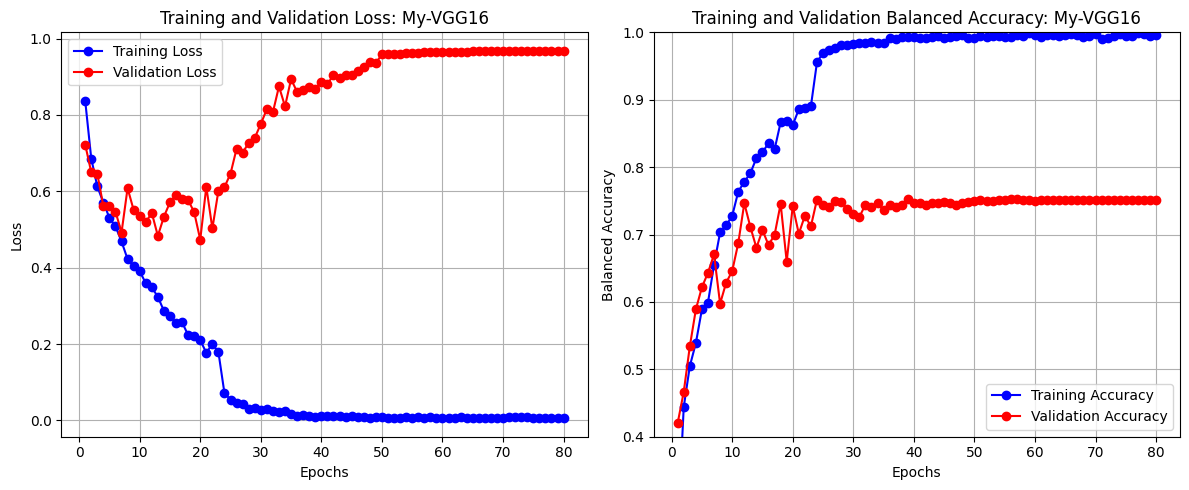

In [22]:
plot_history(vgg16_train_loss_hist, vgg16_val_loss_hist,
             vgg16_train_acc_hist, vgg16_val_acc_hist, 'My-VGG16')

In [20]:
%%time
## Training/Evaluating on validation set resnet50

## set model to devide
resnet50 = resnet50.to(device)

wandb.init(
      # Set the project where this run will be logged
      project="HAM_IMG_Classifier-myresults", 
      # We pass a run name
      name=f"ResNet50 (optimized: dropout=0.2, data aug profile 1)", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "architecture": "Resnet50",
      "dropout": 0.2,
      "dataset": "HAM10K",
      "epochs": epochs,
      "criterion": criterion,
      "weight decay" : 0,
          "scheduler": "True",
          "transforms": ['Rotation', 'Flip', 'Normalization']
      })


##small
#resnet50_val_predictions, resnet50_val_labels, resnet50_train_loss_hist, resnet50_val_loss_hist, resnet50_train_acc_hist, resnet50_net_val_acc_hist = train_loop(resnet50, optimizer_resnet50, scheduler_resnet50, criterion, ds_train_small, ds_val, epochs, num_classes, 'resnet50')
##full
resnet50_val_predictions, resnet50_val_labels, resnet50_train_loss_hist, resnet50_val_loss_hist, resnet50_train_acc_hist, resnet50_val_acc_hist = train_loop(resnet50, optimizer_resnet50, scheduler_resnet50, criterion, ds_train, ds_val, epochs, num_classes, 'resnet50')

# Mark the run as finished
wandb.finish()

wandb: Currently logged in as: pedrocast7 (projects-pedro-ml). Use `wandb login --relogin` to force relogin


Epoch 1/80


100%|██████████| 56/56 [00:08<00:00,  6.23it/s]


Training Loss: 0.7176, Train Balanced Accuracy: 0.3616, Train Accuracy: 0.7394
Validation Loss: 0.5654, Val Balanced Accuracy: 0.5543, Val Accuracy: 0.7891
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 2/80


100%|██████████| 56/56 [00:05<00:00,  9.50it/s]


Training Loss: 0.5373, Train Balanced Accuracy: 0.5719, Train Accuracy: 0.8020
Validation Loss: 0.5664, Val Balanced Accuracy: 0.5789, Val Accuracy: 0.7914
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 3/80


100%|██████████| 56/56 [00:06<00:00,  8.89it/s]


Training Loss: 0.4664, Train Balanced Accuracy: 0.6751, Train Accuracy: 0.8321
Validation Loss: 0.4833, Val Balanced Accuracy: 0.7177, Val Accuracy: 0.8278
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 4/80


100%|██████████| 56/56 [00:06<00:00,  8.98it/s]


Training Loss: 0.4142, Train Balanced Accuracy: 0.6963, Train Accuracy: 0.8489
Validation Loss: 0.5227, Val Balanced Accuracy: 0.6191, Val Accuracy: 0.8099
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 5/80


100%|██████████| 56/56 [00:05<00:00,  9.70it/s]


Training Loss: 0.3670, Train Balanced Accuracy: 0.7333, Train Accuracy: 0.8631
Validation Loss: 0.4558, Val Balanced Accuracy: 0.7038, Val Accuracy: 0.8368
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 6/80


100%|██████████| 56/56 [00:06<00:00,  9.25it/s]


Training Loss: 0.3335, Train Balanced Accuracy: 0.7767, Train Accuracy: 0.8773
Validation Loss: 0.4711, Val Balanced Accuracy: 0.6706, Val Accuracy: 0.8267
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 7/80


100%|██████████| 56/56 [00:05<00:00,  9.49it/s]


Training Loss: 0.3085, Train Balanced Accuracy: 0.7955, Train Accuracy: 0.8872
Validation Loss: 0.4615, Val Balanced Accuracy: 0.7262, Val Accuracy: 0.8374
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 8/80


100%|██████████| 56/56 [00:05<00:00,  9.71it/s]


Training Loss: 0.2729, Train Balanced Accuracy: 0.8241, Train Accuracy: 0.9013
Validation Loss: 0.5225, Val Balanced Accuracy: 0.6535, Val Accuracy: 0.8245
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 9/80


100%|██████████| 56/56 [00:05<00:00,  9.57it/s]


Training Loss: 0.2573, Train Balanced Accuracy: 0.8386, Train Accuracy: 0.9076
Validation Loss: 0.4746, Val Balanced Accuracy: 0.7220, Val Accuracy: 0.8357
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 10/80


100%|██████████| 56/56 [00:05<00:00,  9.54it/s]


Training Loss: 0.2254, Train Balanced Accuracy: 0.8670, Train Accuracy: 0.9181
Validation Loss: 0.5215, Val Balanced Accuracy: 0.6950, Val Accuracy: 0.8351
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 11/80


100%|██████████| 56/56 [00:06<00:00,  8.74it/s]


Training Loss: 0.2125, Train Balanced Accuracy: 0.8667, Train Accuracy: 0.9233
Validation Loss: 0.5219, Val Balanced Accuracy: 0.7177, Val Accuracy: 0.8329
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 12/80


100%|██████████| 56/56 [00:06<00:00,  9.23it/s]


Training Loss: 0.2025, Train Balanced Accuracy: 0.8527, Train Accuracy: 0.9244
Validation Loss: 0.5160, Val Balanced Accuracy: 0.7411, Val Accuracy: 0.8418
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 13/80


100%|██████████| 56/56 [00:05<00:00,  9.43it/s]


Training Loss: 0.1901, Train Balanced Accuracy: 0.8821, Train Accuracy: 0.9297
Validation Loss: 0.5915, Val Balanced Accuracy: 0.7422, Val Accuracy: 0.8446
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 14/80


100%|██████████| 56/56 [00:06<00:00,  9.29it/s]


Training Loss: 0.1800, Train Balanced Accuracy: 0.8832, Train Accuracy: 0.9345
Validation Loss: 0.5367, Val Balanced Accuracy: 0.7554, Val Accuracy: 0.8396
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 15/80


100%|██████████| 56/56 [00:05<00:00,  9.49it/s]


Training Loss: 0.1610, Train Balanced Accuracy: 0.9073, Train Accuracy: 0.9415
Validation Loss: 0.5703, Val Balanced Accuracy: 0.7653, Val Accuracy: 0.8486
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 16/80


100%|██████████| 56/56 [00:05<00:00,  9.58it/s]


Training Loss: 0.1349, Train Balanced Accuracy: 0.9235, Train Accuracy: 0.9498
Validation Loss: 0.5957, Val Balanced Accuracy: 0.7119, Val Accuracy: 0.8435
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 17/80


100%|██████████| 56/56 [00:05<00:00,  9.58it/s]


Training Loss: 0.1351, Train Balanced Accuracy: 0.9313, Train Accuracy: 0.9518
Validation Loss: 0.5474, Val Balanced Accuracy: 0.7483, Val Accuracy: 0.8514
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 18/80


100%|██████████| 56/56 [00:06<00:00,  8.93it/s]


Training Loss: 0.1398, Train Balanced Accuracy: 0.9215, Train Accuracy: 0.9509
Validation Loss: 0.5478, Val Balanced Accuracy: 0.7245, Val Accuracy: 0.8491
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 19/80


100%|██████████| 56/56 [00:05<00:00,  9.64it/s]


Training Loss: 0.1299, Train Balanced Accuracy: 0.9180, Train Accuracy: 0.9546
Validation Loss: 0.5666, Val Balanced Accuracy: 0.7315, Val Accuracy: 0.8581
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 20/80


100%|██████████| 56/56 [00:05<00:00,  9.65it/s]


Training Loss: 0.1092, Train Balanced Accuracy: 0.9398, Train Accuracy: 0.9599
Validation Loss: 0.5103, Val Balanced Accuracy: 0.7756, Val Accuracy: 0.8553
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 21/80


100%|██████████| 56/56 [00:05<00:00,  9.58it/s]


Training Loss: 0.1097, Train Balanced Accuracy: 0.9342, Train Accuracy: 0.9614
Validation Loss: 0.5353, Val Balanced Accuracy: 0.7540, Val Accuracy: 0.8547
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 22/80


100%|██████████| 56/56 [00:05<00:00,  9.50it/s]


Training Loss: 0.1015, Train Balanced Accuracy: 0.9525, Train Accuracy: 0.9635
Validation Loss: 0.6072, Val Balanced Accuracy: 0.7269, Val Accuracy: 0.8446
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 23/80


100%|██████████| 56/56 [00:05<00:00,  9.45it/s]


Training Loss: 0.0974, Train Balanced Accuracy: 0.9508, Train Accuracy: 0.9684
Validation Loss: 0.6715, Val Balanced Accuracy: 0.7157, Val Accuracy: 0.8497
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 24/80


100%|██████████| 56/56 [00:05<00:00,  9.67it/s]


Training Loss: 0.0958, Train Balanced Accuracy: 0.9458, Train Accuracy: 0.9670
Validation Loss: 0.6433, Val Balanced Accuracy: 0.7366, Val Accuracy: 0.8564
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 25/80


100%|██████████| 56/56 [00:06<00:00,  8.93it/s]


Training Loss: 0.0922, Train Balanced Accuracy: 0.9503, Train Accuracy: 0.9670
Validation Loss: 0.5949, Val Balanced Accuracy: 0.7569, Val Accuracy: 0.8598
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 26/80


100%|██████████| 56/56 [00:06<00:00,  9.00it/s]


Training Loss: 0.0829, Train Balanced Accuracy: 0.9620, Train Accuracy: 0.9701
Validation Loss: 0.6333, Val Balanced Accuracy: 0.7397, Val Accuracy: 0.8474
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 27/80


100%|██████████| 56/56 [00:05<00:00,  9.63it/s]


Training Loss: 0.0875, Train Balanced Accuracy: 0.9522, Train Accuracy: 0.9708
Validation Loss: 0.6234, Val Balanced Accuracy: 0.7209, Val Accuracy: 0.8480
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 28/80


100%|██████████| 56/56 [00:05<00:00,  9.62it/s]


Training Loss: 0.0756, Train Balanced Accuracy: 0.9573, Train Accuracy: 0.9746
Validation Loss: 0.6314, Val Balanced Accuracy: 0.7667, Val Accuracy: 0.8486
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 29/80


100%|██████████| 56/56 [00:05<00:00,  9.61it/s]


Training Loss: 0.0819, Train Balanced Accuracy: 0.9578, Train Accuracy: 0.9701
Validation Loss: 0.6337, Val Balanced Accuracy: 0.7620, Val Accuracy: 0.8581
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 30/80


100%|██████████| 56/56 [00:05<00:00,  9.45it/s]


Training Loss: 0.0764, Train Balanced Accuracy: 0.9596, Train Accuracy: 0.9741
Validation Loss: 0.5767, Val Balanced Accuracy: 0.7713, Val Accuracy: 0.8643
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 31/80


100%|██████████| 56/56 [00:05<00:00,  9.68it/s]


Training Loss: 0.0662, Train Balanced Accuracy: 0.9629, Train Accuracy: 0.9776
Validation Loss: 0.5720, Val Balanced Accuracy: 0.7734, Val Accuracy: 0.8648
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 32/80


100%|██████████| 56/56 [00:05<00:00,  9.39it/s]


Training Loss: 0.0372, Train Balanced Accuracy: 0.9860, Train Accuracy: 0.9884
Validation Loss: 0.5755, Val Balanced Accuracy: 0.7687, Val Accuracy: 0.8699
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 33/80


100%|██████████| 56/56 [00:06<00:00,  8.69it/s]


Training Loss: 0.0245, Train Balanced Accuracy: 0.9907, Train Accuracy: 0.9937
Validation Loss: 0.5876, Val Balanced Accuracy: 0.7865, Val Accuracy: 0.8732
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 34/80


100%|██████████| 56/56 [00:05<00:00,  9.63it/s]


Training Loss: 0.0190, Train Balanced Accuracy: 0.9901, Train Accuracy: 0.9940
Validation Loss: 0.6133, Val Balanced Accuracy: 0.7850, Val Accuracy: 0.8777
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 35/80


100%|██████████| 56/56 [00:05<00:00,  9.67it/s]


Training Loss: 0.0172, Train Balanced Accuracy: 0.9904, Train Accuracy: 0.9944
Validation Loss: 0.6263, Val Balanced Accuracy: 0.7864, Val Accuracy: 0.8800
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 36/80


100%|██████████| 56/56 [00:05<00:00,  9.58it/s]


Training Loss: 0.0143, Train Balanced Accuracy: 0.9928, Train Accuracy: 0.9957
Validation Loss: 0.6396, Val Balanced Accuracy: 0.7997, Val Accuracy: 0.8732
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 37/80


100%|██████████| 56/56 [00:05<00:00,  9.60it/s]


Training Loss: 0.0133, Train Balanced Accuracy: 0.9908, Train Accuracy: 0.9955
Validation Loss: 0.6602, Val Balanced Accuracy: 0.7951, Val Accuracy: 0.8761
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 38/80


100%|██████████| 56/56 [00:05<00:00,  9.60it/s]


Training Loss: 0.0138, Train Balanced Accuracy: 0.9928, Train Accuracy: 0.9952
Validation Loss: 0.6915, Val Balanced Accuracy: 0.7851, Val Accuracy: 0.8772
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 39/80


100%|██████████| 56/56 [00:05<00:00,  9.63it/s]


Training Loss: 0.0087, Train Balanced Accuracy: 0.9957, Train Accuracy: 0.9973
Validation Loss: 0.7051, Val Balanced Accuracy: 0.7785, Val Accuracy: 0.8772
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 40/80


100%|██████████| 56/56 [00:06<00:00,  8.90it/s]


Training Loss: 0.0137, Train Balanced Accuracy: 0.9934, Train Accuracy: 0.9959
Validation Loss: 0.7074, Val Balanced Accuracy: 0.7730, Val Accuracy: 0.8761
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 41/80


100%|██████████| 56/56 [00:06<00:00,  9.12it/s]


Training Loss: 0.0084, Train Balanced Accuracy: 0.9962, Train Accuracy: 0.9978
Validation Loss: 0.7167, Val Balanced Accuracy: 0.7670, Val Accuracy: 0.8710
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 42/80


100%|██████████| 56/56 [00:05<00:00,  9.59it/s]


Training Loss: 0.0081, Train Balanced Accuracy: 0.9964, Train Accuracy: 0.9971
Validation Loss: 0.7346, Val Balanced Accuracy: 0.7785, Val Accuracy: 0.8777
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 43/80


100%|██████████| 56/56 [00:05<00:00,  9.43it/s]


Training Loss: 0.0072, Train Balanced Accuracy: 0.9959, Train Accuracy: 0.9980
Validation Loss: 0.7275, Val Balanced Accuracy: 0.7817, Val Accuracy: 0.8794
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 44/80


100%|██████████| 56/56 [00:05<00:00,  9.55it/s]


Training Loss: 0.0093, Train Balanced Accuracy: 0.9950, Train Accuracy: 0.9968
Validation Loss: 0.7606, Val Balanced Accuracy: 0.7760, Val Accuracy: 0.8732
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 45/80


100%|██████████| 56/56 [00:05<00:00,  9.73it/s]


Training Loss: 0.0087, Train Balanced Accuracy: 0.9940, Train Accuracy: 0.9969
Validation Loss: 0.7505, Val Balanced Accuracy: 0.7816, Val Accuracy: 0.8755
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 46/80


100%|██████████| 56/56 [00:05<00:00,  9.64it/s]


Training Loss: 0.0054, Train Balanced Accuracy: 0.9981, Train Accuracy: 0.9986
Validation Loss: 0.7567, Val Balanced Accuracy: 0.7775, Val Accuracy: 0.8811
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 47/80


100%|██████████| 56/56 [00:05<00:00,  9.61it/s]


Training Loss: 0.0065, Train Balanced Accuracy: 0.9979, Train Accuracy: 0.9985
Validation Loss: 0.7498, Val Balanced Accuracy: 0.7656, Val Accuracy: 0.8749
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 48/80


100%|██████████| 56/56 [00:06<00:00,  8.80it/s]


Training Loss: 0.0052, Train Balanced Accuracy: 0.9977, Train Accuracy: 0.9985
Validation Loss: 0.7749, Val Balanced Accuracy: 0.7719, Val Accuracy: 0.8761
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 49/80


100%|██████████| 56/56 [00:05<00:00,  9.39it/s]


Training Loss: 0.0081, Train Balanced Accuracy: 0.9984, Train Accuracy: 0.9985
Validation Loss: 0.7686, Val Balanced Accuracy: 0.7750, Val Accuracy: 0.8744
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 50/80


100%|██████████| 56/56 [00:05<00:00,  9.47it/s]


Training Loss: 0.0063, Train Balanced Accuracy: 0.9981, Train Accuracy: 0.9979
Validation Loss: 0.7642, Val Balanced Accuracy: 0.7788, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 51/80


100%|██████████| 56/56 [00:05<00:00,  9.64it/s]


Training Loss: 0.0039, Train Balanced Accuracy: 0.9986, Train Accuracy: 0.9987
Validation Loss: 0.7806, Val Balanced Accuracy: 0.7746, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 52/80


100%|██████████| 56/56 [00:05<00:00,  9.55it/s]


Training Loss: 0.0029, Train Balanced Accuracy: 0.9980, Train Accuracy: 0.9990
Validation Loss: 0.7785, Val Balanced Accuracy: 0.7727, Val Accuracy: 0.8721
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 53/80


100%|██████████| 56/56 [00:05<00:00,  9.54it/s]


Training Loss: 0.0059, Train Balanced Accuracy: 0.9982, Train Accuracy: 0.9985
Validation Loss: 0.7750, Val Balanced Accuracy: 0.7675, Val Accuracy: 0.8732
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 54/80


100%|██████████| 56/56 [00:05<00:00,  9.58it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9992
Validation Loss: 0.7848, Val Balanced Accuracy: 0.7775, Val Accuracy: 0.8755
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 55/80


100%|██████████| 56/56 [00:06<00:00,  9.18it/s]


Training Loss: 0.0054, Train Balanced Accuracy: 0.9979, Train Accuracy: 0.9982
Validation Loss: 0.7633, Val Balanced Accuracy: 0.7837, Val Accuracy: 0.8761
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 56/80


100%|██████████| 56/56 [00:06<00:00,  8.73it/s]


Training Loss: 0.0039, Train Balanced Accuracy: 0.9993, Train Accuracy: 0.9990
Validation Loss: 0.7766, Val Balanced Accuracy: 0.7702, Val Accuracy: 0.8761
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 57/80


100%|██████████| 56/56 [00:05<00:00,  9.63it/s]


Training Loss: 0.0031, Train Balanced Accuracy: 0.9988, Train Accuracy: 0.9990
Validation Loss: 0.7762, Val Balanced Accuracy: 0.7784, Val Accuracy: 0.8738
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 58/80


100%|██████████| 56/56 [00:05<00:00,  9.54it/s]


Training Loss: 0.0039, Train Balanced Accuracy: 0.9969, Train Accuracy: 0.9987
Validation Loss: 0.7927, Val Balanced Accuracy: 0.7726, Val Accuracy: 0.8783
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 59/80


100%|██████████| 56/56 [00:05<00:00,  9.35it/s]


Training Loss: 0.0033, Train Balanced Accuracy: 0.9989, Train Accuracy: 0.9990
Validation Loss: 0.7857, Val Balanced Accuracy: 0.7778, Val Accuracy: 0.8777
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 60/80


100%|██████████| 56/56 [00:05<00:00,  9.64it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9992
Validation Loss: 0.7843, Val Balanced Accuracy: 0.7842, Val Accuracy: 0.8777
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 61/80


100%|██████████| 56/56 [00:05<00:00,  9.54it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9991, Train Accuracy: 0.9994
Validation Loss: 0.7773, Val Balanced Accuracy: 0.7743, Val Accuracy: 0.8738
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 62/80


100%|██████████| 56/56 [00:05<00:00,  9.68it/s]


Training Loss: 0.0039, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9987
Validation Loss: 0.7918, Val Balanced Accuracy: 0.7862, Val Accuracy: 0.8777
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 63/80


100%|██████████| 56/56 [00:06<00:00,  8.85it/s]


Training Loss: 0.0038, Train Balanced Accuracy: 0.9985, Train Accuracy: 0.9987
Validation Loss: 0.7911, Val Balanced Accuracy: 0.7747, Val Accuracy: 0.8783
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 64/80


100%|██████████| 56/56 [00:05<00:00,  9.49it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9992
Validation Loss: 0.7826, Val Balanced Accuracy: 0.7925, Val Accuracy: 0.8805
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 65/80


100%|██████████| 56/56 [00:05<00:00,  9.54it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9988, Train Accuracy: 0.9992
Validation Loss: 0.7907, Val Balanced Accuracy: 0.7756, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 66/80


100%|██████████| 56/56 [00:05<00:00,  9.45it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9993
Validation Loss: 0.7864, Val Balanced Accuracy: 0.7769, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 67/80


100%|██████████| 56/56 [00:05<00:00,  9.57it/s]


Training Loss: 0.0038, Train Balanced Accuracy: 0.9984, Train Accuracy: 0.9987
Validation Loss: 0.7925, Val Balanced Accuracy: 0.7753, Val Accuracy: 0.8761
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 68/80


100%|██████████| 56/56 [00:05<00:00,  9.61it/s]


Training Loss: 0.0031, Train Balanced Accuracy: 0.9991, Train Accuracy: 0.9992
Validation Loss: 0.7839, Val Balanced Accuracy: 0.7715, Val Accuracy: 0.8721
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 69/80


100%|██████████| 56/56 [00:05<00:00,  9.69it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9993
Validation Loss: 0.7737, Val Balanced Accuracy: 0.7827, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 70/80


100%|██████████| 56/56 [00:05<00:00,  9.43it/s]


Training Loss: 0.0032, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9993
Validation Loss: 0.7929, Val Balanced Accuracy: 0.7695, Val Accuracy: 0.8755
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 71/80


100%|██████████| 56/56 [00:06<00:00,  8.91it/s]


Training Loss: 0.0032, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9993
Validation Loss: 0.7682, Val Balanced Accuracy: 0.7901, Val Accuracy: 0.8800
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 72/80


100%|██████████| 56/56 [00:05<00:00,  9.62it/s]


Training Loss: 0.0040, Train Balanced Accuracy: 0.9985, Train Accuracy: 0.9986
Validation Loss: 0.7835, Val Balanced Accuracy: 0.7810, Val Accuracy: 0.8761
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 73/80


100%|██████████| 56/56 [00:05<00:00,  9.62it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9986, Train Accuracy: 0.9990
Validation Loss: 0.7915, Val Balanced Accuracy: 0.7812, Val Accuracy: 0.8749
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 74/80


100%|██████████| 56/56 [00:05<00:00,  9.67it/s]


Training Loss: 0.0034, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9989
Validation Loss: 0.7815, Val Balanced Accuracy: 0.7784, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 75/80


100%|██████████| 56/56 [00:05<00:00,  9.54it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9979, Train Accuracy: 0.9992
Validation Loss: 0.8010, Val Balanced Accuracy: 0.7612, Val Accuracy: 0.8727
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 76/80


100%|██████████| 56/56 [00:05<00:00,  9.55it/s]


Training Loss: 0.0022, Train Balanced Accuracy: 0.9990, Train Accuracy: 0.9993
Validation Loss: 0.8055, Val Balanced Accuracy: 0.7750, Val Accuracy: 0.8755
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 77/80


100%|██████████| 56/56 [00:05<00:00,  9.62it/s]


Training Loss: 0.0024, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9994
Validation Loss: 0.7897, Val Balanced Accuracy: 0.7859, Val Accuracy: 0.8800
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 78/80


100%|██████████| 56/56 [00:06<00:00,  8.89it/s]


Training Loss: 0.0034, Train Balanced Accuracy: 0.9993, Train Accuracy: 0.9990
Validation Loss: 0.7868, Val Balanced Accuracy: 0.7881, Val Accuracy: 0.8777
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 79/80


100%|██████████| 56/56 [00:06<00:00,  9.02it/s]


Training Loss: 0.0043, Train Balanced Accuracy: 0.9974, Train Accuracy: 0.9987
Validation Loss: 0.7970, Val Balanced Accuracy: 0.7820, Val Accuracy: 0.8772
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 80/80


100%|██████████| 56/56 [00:05<00:00,  9.56it/s]


Training Loss: 0.0040, Train Balanced Accuracy: 0.9976, Train Accuracy: 0.9986
Validation Loss: 0.8021, Val Balanced Accuracy: 0.7736, Val Accuracy: 0.8755
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Best Results at epoch 35. Val Balanced Accuracy = 0.7997498296953134





CPU times: user 23min 18s, sys: 1min 9s, total: 24min 28s
Wall time: 48min 30s


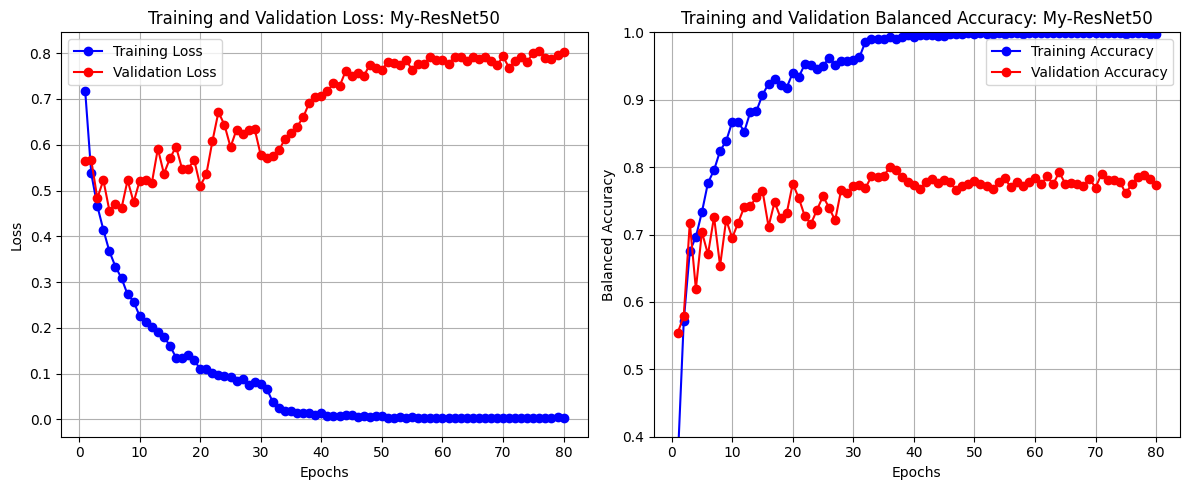

In [21]:
plot_history(resnet50_train_loss_hist, resnet50_val_loss_hist,
             resnet50_train_acc_hist, resnet50_val_acc_hist, 'My-ResNet50')

In [21]:
%%time
## Training/Evaluating on validation set densenet

## set model to devide
densenet = densenet.to(device)

wandb.init(
      # Set the project where this run will be logged
      project="HAM_IMG_Classifier-myresults",
      # We pass a run name
      name=f"DenseNet (optimized: dropout=0.2, data aug profile 1)", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "architecture": "Densenet",
      "dropout": 0.2,
      "dataset": "HAM10K",
      "epochs": epochs,
      "criterion": criterion,
      "weight decay" : 0,
          "scheduler": "True",
          "transforms": ['Rotation', 'Flip', 'Normalization']
      })

##small
#densenet_val_predictions, densenet_val_labels, densenet_train_loss_hist, densenet_val_loss_hist, densenet_train_acc_hist, densenet_val_acc_hist = train_loop(densenet, optimizer_densenet, scheduler_densenet, criterion, ds_train_small, ds_val, epochs, num_classes, 'densenet')
##full
densenet_val_predictions, densenet_val_labels, densenet_train_loss_hist, densenet_val_loss_hist, densenet_train_acc_hist, densenet_val_acc_hist = train_loop(densenet, optimizer_densenet, scheduler_densenet, criterion, ds_train, ds_val, epochs, num_classes, 'densenet')

# Mark the run as finished
wandb.finish()

wandb: Currently logged in as: pedrocast7 (projects-pedro-ml). Use `wandb login --relogin` to force relogin


Epoch 1/80


100%|██████████| 56/56 [00:10<00:00,  5.43it/s]


Training Loss: 0.7088, Train Balanced Accuracy: 0.3728, Train Accuracy: 0.7512
Validation Loss: 0.5612, Val Balanced Accuracy: 0.5754, Val Accuracy: 0.7975
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 2/80


100%|██████████| 56/56 [00:06<00:00,  9.00it/s]


Training Loss: 0.4968, Train Balanced Accuracy: 0.6121, Train Accuracy: 0.8160
Validation Loss: 0.5256, Val Balanced Accuracy: 0.6347, Val Accuracy: 0.7975
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 3/80


100%|██████████| 56/56 [00:06<00:00,  8.36it/s]


Training Loss: 0.4053, Train Balanced Accuracy: 0.7150, Train Accuracy: 0.8536
Validation Loss: 0.4469, Val Balanced Accuracy: 0.6990, Val Accuracy: 0.8458
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 4/80


100%|██████████| 56/56 [00:06<00:00,  8.83it/s]


Training Loss: 0.3396, Train Balanced Accuracy: 0.7753, Train Accuracy: 0.8773
Validation Loss: 0.5056, Val Balanced Accuracy: 0.6987, Val Accuracy: 0.8351
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 5/80


100%|██████████| 56/56 [00:06<00:00,  8.90it/s]


Training Loss: 0.2950, Train Balanced Accuracy: 0.7958, Train Accuracy: 0.8888
Validation Loss: 0.4541, Val Balanced Accuracy: 0.6882, Val Accuracy: 0.8385
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 6/80


100%|██████████| 56/56 [00:06<00:00,  8.33it/s]


Training Loss: 0.2628, Train Balanced Accuracy: 0.8413, Train Accuracy: 0.9059
Validation Loss: 0.4948, Val Balanced Accuracy: 0.7040, Val Accuracy: 0.8413
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 7/80


100%|██████████| 56/56 [00:06<00:00,  8.73it/s]


Training Loss: 0.2290, Train Balanced Accuracy: 0.8518, Train Accuracy: 0.9157
Validation Loss: 0.4685, Val Balanced Accuracy: 0.7452, Val Accuracy: 0.8547
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 8/80


100%|██████████| 56/56 [00:06<00:00,  8.87it/s]


Training Loss: 0.1881, Train Balanced Accuracy: 0.8878, Train Accuracy: 0.9310
Validation Loss: 0.4967, Val Balanced Accuracy: 0.7840, Val Accuracy: 0.8575
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 9/80


100%|██████████| 56/56 [00:06<00:00,  8.21it/s]


Training Loss: 0.1682, Train Balanced Accuracy: 0.8967, Train Accuracy: 0.9376
Validation Loss: 0.5014, Val Balanced Accuracy: 0.7294, Val Accuracy: 0.8486
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 10/80


100%|██████████| 56/56 [00:06<00:00,  8.70it/s]


Training Loss: 0.1613, Train Balanced Accuracy: 0.9112, Train Accuracy: 0.9460
Validation Loss: 0.5640, Val Balanced Accuracy: 0.7871, Val Accuracy: 0.8542
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 11/80


100%|██████████| 56/56 [00:06<00:00,  9.03it/s]


Training Loss: 0.1510, Train Balanced Accuracy: 0.9049, Train Accuracy: 0.9445
Validation Loss: 0.5251, Val Balanced Accuracy: 0.7735, Val Accuracy: 0.8514
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 12/80


100%|██████████| 56/56 [00:06<00:00,  8.91it/s]


Training Loss: 0.1090, Train Balanced Accuracy: 0.9431, Train Accuracy: 0.9593
Validation Loss: 0.5492, Val Balanced Accuracy: 0.7606, Val Accuracy: 0.8486
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 13/80


100%|██████████| 56/56 [00:06<00:00,  8.83it/s]


Training Loss: 0.1071, Train Balanced Accuracy: 0.9366, Train Accuracy: 0.9626
Validation Loss: 0.6086, Val Balanced Accuracy: 0.7458, Val Accuracy: 0.8514
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 14/80


100%|██████████| 56/56 [00:06<00:00,  8.81it/s]


Training Loss: 0.1174, Train Balanced Accuracy: 0.9377, Train Accuracy: 0.9592
Validation Loss: 0.5725, Val Balanced Accuracy: 0.7008, Val Accuracy: 0.8480
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 15/80


100%|██████████| 56/56 [00:06<00:00,  8.92it/s]


Training Loss: 0.0952, Train Balanced Accuracy: 0.9436, Train Accuracy: 0.9659
Validation Loss: 0.6856, Val Balanced Accuracy: 0.7601, Val Accuracy: 0.8575
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 16/80


100%|██████████| 56/56 [00:06<00:00,  9.03it/s]


Training Loss: 0.0832, Train Balanced Accuracy: 0.9584, Train Accuracy: 0.9715
Validation Loss: 0.8395, Val Balanced Accuracy: 0.7105, Val Accuracy: 0.8469
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 17/80


100%|██████████| 56/56 [00:06<00:00,  9.01it/s]


Training Loss: 0.1046, Train Balanced Accuracy: 0.9462, Train Accuracy: 0.9658
Validation Loss: 0.6037, Val Balanced Accuracy: 0.7623, Val Accuracy: 0.8497
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 18/80


100%|██████████| 56/56 [00:06<00:00,  8.85it/s]


Training Loss: 0.0724, Train Balanced Accuracy: 0.9594, Train Accuracy: 0.9745
Validation Loss: 0.6576, Val Balanced Accuracy: 0.7564, Val Accuracy: 0.8671
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 19/80


100%|██████████| 56/56 [00:06<00:00,  8.78it/s]


Training Loss: 0.0768, Train Balanced Accuracy: 0.9648, Train Accuracy: 0.9734
Validation Loss: 0.6832, Val Balanced Accuracy: 0.7285, Val Accuracy: 0.8547
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 20/80


100%|██████████| 56/56 [00:06<00:00,  8.69it/s]


Training Loss: 0.0709, Train Balanced Accuracy: 0.9623, Train Accuracy: 0.9757
Validation Loss: 0.6854, Val Balanced Accuracy: 0.7354, Val Accuracy: 0.8542
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 21/80


100%|██████████| 56/56 [00:06<00:00,  8.98it/s]


Training Loss: 0.0656, Train Balanced Accuracy: 0.9663, Train Accuracy: 0.9783
Validation Loss: 0.6820, Val Balanced Accuracy: 0.7386, Val Accuracy: 0.8632
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 22/80


100%|██████████| 56/56 [00:06<00:00,  8.86it/s]


Training Loss: 0.0363, Train Balanced Accuracy: 0.9780, Train Accuracy: 0.9875
Validation Loss: 0.6082, Val Balanced Accuracy: 0.7640, Val Accuracy: 0.8749
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 23/80


100%|██████████| 56/56 [00:06<00:00,  8.37it/s]


Training Loss: 0.0228, Train Balanced Accuracy: 0.9910, Train Accuracy: 0.9937
Validation Loss: 0.5952, Val Balanced Accuracy: 0.7969, Val Accuracy: 0.8817
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 24/80


100%|██████████| 56/56 [00:06<00:00,  8.87it/s]


Training Loss: 0.0167, Train Balanced Accuracy: 0.9921, Train Accuracy: 0.9952
Validation Loss: 0.6128, Val Balanced Accuracy: 0.7931, Val Accuracy: 0.8800
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 25/80


100%|██████████| 56/56 [00:06<00:00,  8.88it/s]


Training Loss: 0.0127, Train Balanced Accuracy: 0.9944, Train Accuracy: 0.9975
Validation Loss: 0.6183, Val Balanced Accuracy: 0.7921, Val Accuracy: 0.8789
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 26/80


100%|██████████| 56/56 [00:06<00:00,  8.36it/s]


Training Loss: 0.0120, Train Balanced Accuracy: 0.9944, Train Accuracy: 0.9965
Validation Loss: 0.6159, Val Balanced Accuracy: 0.7900, Val Accuracy: 0.8794
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 27/80


100%|██████████| 56/56 [00:06<00:00,  8.83it/s]


Training Loss: 0.0126, Train Balanced Accuracy: 0.9919, Train Accuracy: 0.9958
Validation Loss: 0.6367, Val Balanced Accuracy: 0.7965, Val Accuracy: 0.8828
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 28/80


100%|██████████| 56/56 [00:06<00:00,  8.93it/s]


Training Loss: 0.0078, Train Balanced Accuracy: 0.9962, Train Accuracy: 0.9978
Validation Loss: 0.6529, Val Balanced Accuracy: 0.8044, Val Accuracy: 0.8828
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 29/80


100%|██████████| 56/56 [00:06<00:00,  8.37it/s]


Training Loss: 0.0067, Train Balanced Accuracy: 0.9984, Train Accuracy: 0.9983
Validation Loss: 0.6756, Val Balanced Accuracy: 0.7888, Val Accuracy: 0.8833
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 30/80


100%|██████████| 56/56 [00:06<00:00,  8.98it/s]


Training Loss: 0.0066, Train Balanced Accuracy: 0.9980, Train Accuracy: 0.9982
Validation Loss: 0.6969, Val Balanced Accuracy: 0.7914, Val Accuracy: 0.8817
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 31/80


100%|██████████| 56/56 [00:06<00:00,  9.05it/s]


Training Loss: 0.0069, Train Balanced Accuracy: 0.9989, Train Accuracy: 0.9985
Validation Loss: 0.7107, Val Balanced Accuracy: 0.7796, Val Accuracy: 0.8839
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 32/80


100%|██████████| 56/56 [00:06<00:00,  8.39it/s]


Training Loss: 0.0049, Train Balanced Accuracy: 0.9970, Train Accuracy: 0.9986
Validation Loss: 0.6804, Val Balanced Accuracy: 0.7827, Val Accuracy: 0.8777
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 33/80


100%|██████████| 56/56 [00:06<00:00,  8.96it/s]


Training Loss: 0.0064, Train Balanced Accuracy: 0.9965, Train Accuracy: 0.9979
Validation Loss: 0.7221, Val Balanced Accuracy: 0.7894, Val Accuracy: 0.8839
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 34/80


100%|██████████| 56/56 [00:06<00:00,  8.86it/s]


Training Loss: 0.0053, Train Balanced Accuracy: 0.9990, Train Accuracy: 0.9987
Validation Loss: 0.7341, Val Balanced Accuracy: 0.7801, Val Accuracy: 0.8828
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 35/80


100%|██████████| 56/56 [00:06<00:00,  8.83it/s]


Training Loss: 0.0041, Train Balanced Accuracy: 0.9988, Train Accuracy: 0.9990
Validation Loss: 0.7044, Val Balanced Accuracy: 0.7914, Val Accuracy: 0.8861
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 36/80


100%|██████████| 56/56 [00:06<00:00,  8.84it/s]


Training Loss: 0.0023, Train Balanced Accuracy: 0.9998, Train Accuracy: 0.9996
Validation Loss: 0.7167, Val Balanced Accuracy: 0.7907, Val Accuracy: 0.8861
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 37/80


100%|██████████| 56/56 [00:06<00:00,  8.94it/s]


Training Loss: 0.0025, Train Balanced Accuracy: 0.9985, Train Accuracy: 0.9992
Validation Loss: 0.7420, Val Balanced Accuracy: 0.7930, Val Accuracy: 0.8861
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 38/80


100%|██████████| 56/56 [00:06<00:00,  8.90it/s]


Training Loss: 0.0040, Train Balanced Accuracy: 0.9984, Train Accuracy: 0.9986
Validation Loss: 0.7245, Val Balanced Accuracy: 0.7901, Val Accuracy: 0.8850
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 39/80


100%|██████████| 56/56 [00:06<00:00,  8.96it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9990
Validation Loss: 0.7386, Val Balanced Accuracy: 0.7898, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 40/80


100%|██████████| 56/56 [00:06<00:00,  8.78it/s]


Training Loss: 0.0024, Train Balanced Accuracy: 0.9995, Train Accuracy: 0.9996
Validation Loss: 0.7350, Val Balanced Accuracy: 0.7926, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 41/80


100%|██████████| 56/56 [00:06<00:00,  8.99it/s]


Training Loss: 0.0029, Train Balanced Accuracy: 0.9976, Train Accuracy: 0.9993
Validation Loss: 0.7297, Val Balanced Accuracy: 0.7979, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 42/80


100%|██████████| 56/56 [00:06<00:00,  8.89it/s]


Training Loss: 0.0030, Train Balanced Accuracy: 0.9963, Train Accuracy: 0.9989
Validation Loss: 0.7452, Val Balanced Accuracy: 0.7946, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 43/80


100%|██████████| 56/56 [00:06<00:00,  8.81it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9986, Train Accuracy: 0.9992
Validation Loss: 0.7289, Val Balanced Accuracy: 0.7898, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 44/80


100%|██████████| 56/56 [00:06<00:00,  9.04it/s]


Training Loss: 0.0026, Train Balanced Accuracy: 0.9971, Train Accuracy: 0.9992
Validation Loss: 0.7569, Val Balanced Accuracy: 0.7897, Val Accuracy: 0.8867
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 45/80


100%|██████████| 56/56 [00:06<00:00,  8.80it/s]


Training Loss: 0.0029, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9987
Validation Loss: 0.7490, Val Balanced Accuracy: 0.7917, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 46/80


100%|██████████| 56/56 [00:06<00:00,  8.96it/s]


Training Loss: 0.0041, Train Balanced Accuracy: 0.9980, Train Accuracy: 0.9985
Validation Loss: 0.7371, Val Balanced Accuracy: 0.7930, Val Accuracy: 0.8884
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 47/80


100%|██████████| 56/56 [00:06<00:00,  8.87it/s]


Training Loss: 0.0031, Train Balanced Accuracy: 0.9988, Train Accuracy: 0.9993
Validation Loss: 0.7378, Val Balanced Accuracy: 0.7911, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 48/80


100%|██████████| 56/56 [00:06<00:00,  9.01it/s]


Training Loss: 0.0018, Train Balanced Accuracy: 0.9996, Train Accuracy: 0.9994
Validation Loss: 0.7585, Val Balanced Accuracy: 0.7854, Val Accuracy: 0.8833
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 49/80


100%|██████████| 56/56 [00:06<00:00,  8.45it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9994
Validation Loss: 0.7510, Val Balanced Accuracy: 0.7891, Val Accuracy: 0.8839
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 50/80


100%|██████████| 56/56 [00:06<00:00,  8.98it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9989, Train Accuracy: 0.9992
Validation Loss: 0.7339, Val Balanced Accuracy: 0.7938, Val Accuracy: 0.8878
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 51/80


100%|██████████| 56/56 [00:06<00:00,  8.85it/s]


Training Loss: 0.0027, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9994
Validation Loss: 0.7563, Val Balanced Accuracy: 0.7893, Val Accuracy: 0.8828
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 52/80


100%|██████████| 56/56 [00:06<00:00,  8.40it/s]


Training Loss: 0.0026, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9993
Validation Loss: 0.7521, Val Balanced Accuracy: 0.7954, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 53/80


100%|██████████| 56/56 [00:06<00:00,  8.84it/s]


Training Loss: 0.0026, Train Balanced Accuracy: 0.9989, Train Accuracy: 0.9992
Validation Loss: 0.7478, Val Balanced Accuracy: 0.7899, Val Accuracy: 0.8833
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 54/80


100%|██████████| 56/56 [00:06<00:00,  8.98it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9993
Validation Loss: 0.7529, Val Balanced Accuracy: 0.7966, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 55/80


100%|██████████| 56/56 [00:06<00:00,  8.30it/s]


Training Loss: 0.0034, Train Balanced Accuracy: 0.9991, Train Accuracy: 0.9990
Validation Loss: 0.7377, Val Balanced Accuracy: 0.7954, Val Accuracy: 0.8867
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 56/80


100%|██████████| 56/56 [00:06<00:00,  9.05it/s]


Training Loss: 0.0022, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9993
Validation Loss: 0.7628, Val Balanced Accuracy: 0.7892, Val Accuracy: 0.8845
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 57/80


100%|██████████| 56/56 [00:06<00:00,  8.65it/s]


Training Loss: 0.0027, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9997
Validation Loss: 0.7458, Val Balanced Accuracy: 0.7901, Val Accuracy: 0.8878
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 58/80


100%|██████████| 56/56 [00:06<00:00,  8.27it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9993
Validation Loss: 0.7355, Val Balanced Accuracy: 0.7948, Val Accuracy: 0.8873
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 59/80


100%|██████████| 56/56 [00:06<00:00,  9.00it/s]


Training Loss: 0.0016, Train Balanced Accuracy: 1.0000, Train Accuracy: 0.9999
Validation Loss: 0.7407, Val Balanced Accuracy: 0.7890, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 60/80


100%|██████████| 56/56 [00:06<00:00,  9.02it/s]


Training Loss: 0.0037, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9992
Validation Loss: 0.7515, Val Balanced Accuracy: 0.7884, Val Accuracy: 0.8833
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 61/80


100%|██████████| 56/56 [00:06<00:00,  8.22it/s]


Training Loss: 0.0025, Train Balanced Accuracy: 0.9983, Train Accuracy: 0.9992
Validation Loss: 0.7286, Val Balanced Accuracy: 0.7962, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 62/80


100%|██████████| 56/56 [00:06<00:00,  9.04it/s]


Training Loss: 0.0014, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9999
Validation Loss: 0.7438, Val Balanced Accuracy: 0.7901, Val Accuracy: 0.8845
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 63/80


100%|██████████| 56/56 [00:06<00:00,  9.05it/s]


Training Loss: 0.0030, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9992
Validation Loss: 0.7689, Val Balanced Accuracy: 0.7898, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 64/80


100%|██████████| 56/56 [00:06<00:00,  8.50it/s]


Training Loss: 0.0023, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9993
Validation Loss: 0.7413, Val Balanced Accuracy: 0.7884, Val Accuracy: 0.8822
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 65/80


100%|██████████| 56/56 [00:06<00:00,  8.91it/s]


Training Loss: 0.0023, Train Balanced Accuracy: 0.9970, Train Accuracy: 0.9993
Validation Loss: 0.7515, Val Balanced Accuracy: 0.7867, Val Accuracy: 0.8850
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 66/80


100%|██████████| 56/56 [00:06<00:00,  8.96it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9990, Train Accuracy: 0.9992
Validation Loss: 0.7400, Val Balanced Accuracy: 0.7893, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 67/80


100%|██████████| 56/56 [00:06<00:00,  8.45it/s]


Training Loss: 0.0017, Train Balanced Accuracy: 0.9996, Train Accuracy: 0.9997
Validation Loss: 0.7384, Val Balanced Accuracy: 0.7959, Val Accuracy: 0.8884
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 68/80


100%|██████████| 56/56 [00:06<00:00,  8.95it/s]


Training Loss: 0.0017, Train Balanced Accuracy: 1.0000, Train Accuracy: 1.0000
Validation Loss: 0.7427, Val Balanced Accuracy: 0.7898, Val Accuracy: 0.8856
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 69/80


100%|██████████| 56/56 [00:06<00:00,  8.98it/s]


Training Loss: 0.0022, Train Balanced Accuracy: 0.9991, Train Accuracy: 0.9992
Validation Loss: 0.7419, Val Balanced Accuracy: 0.7976, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 70/80


100%|██████████| 56/56 [00:06<00:00,  8.30it/s]


Training Loss: 0.0023, Train Balanced Accuracy: 0.9995, Train Accuracy: 0.9996
Validation Loss: 0.7620, Val Balanced Accuracy: 0.7888, Val Accuracy: 0.8867
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 71/80


100%|██████████| 56/56 [00:06<00:00,  9.01it/s]


Training Loss: 0.0022, Train Balanced Accuracy: 0.9995, Train Accuracy: 0.9996
Validation Loss: 0.7368, Val Balanced Accuracy: 0.7867, Val Accuracy: 0.8811
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 72/80


100%|██████████| 56/56 [00:06<00:00,  8.97it/s]


Training Loss: 0.0023, Train Balanced Accuracy: 0.9991, Train Accuracy: 0.9994
Validation Loss: 0.7416, Val Balanced Accuracy: 0.7874, Val Accuracy: 0.8811
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 73/80


100%|██████████| 56/56 [00:06<00:00,  8.42it/s]


Training Loss: 0.0017, Train Balanced Accuracy: 0.9996, Train Accuracy: 0.9997
Validation Loss: 0.7516, Val Balanced Accuracy: 0.7923, Val Accuracy: 0.8873
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 74/80


100%|██████████| 56/56 [00:06<00:00,  8.85it/s]


Training Loss: 0.0031, Train Balanced Accuracy: 0.9992, Train Accuracy: 0.9989
Validation Loss: 0.7204, Val Balanced Accuracy: 0.7913, Val Accuracy: 0.8884
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 75/80


100%|██████████| 56/56 [00:06<00:00,  9.10it/s]


Training Loss: 0.0027, Train Balanced Accuracy: 0.9980, Train Accuracy: 0.9992
Validation Loss: 0.7404, Val Balanced Accuracy: 0.7883, Val Accuracy: 0.8878
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 76/80


100%|██████████| 56/56 [00:06<00:00,  8.48it/s]


Training Loss: 0.0030, Train Balanced Accuracy: 0.9987, Train Accuracy: 0.9987
Validation Loss: 0.7597, Val Balanced Accuracy: 0.7864, Val Accuracy: 0.8856
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 77/80


100%|██████████| 56/56 [00:06<00:00,  8.93it/s]


Training Loss: 0.0018, Train Balanced Accuracy: 0.9998, Train Accuracy: 0.9996
Validation Loss: 0.7469, Val Balanced Accuracy: 0.7946, Val Accuracy: 0.8839
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 78/80


100%|██████████| 56/56 [00:06<00:00,  8.89it/s]


Training Loss: 0.0029, Train Balanced Accuracy: 0.9988, Train Accuracy: 0.9992
Validation Loss: 0.7241, Val Balanced Accuracy: 0.7907, Val Accuracy: 0.8845
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 79/80


100%|██████████| 56/56 [00:06<00:00,  8.43it/s]


Training Loss: 0.0028, Train Balanced Accuracy: 0.9994, Train Accuracy: 0.9994
Validation Loss: 0.7583, Val Balanced Accuracy: 0.7854, Val Accuracy: 0.8861
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Epoch 80/80


100%|██████████| 56/56 [00:06<00:00,  8.99it/s]


Training Loss: 0.0035, Train Balanced Accuracy: 0.9991, Train Accuracy: 0.9992
Validation Loss: 0.7617, Val Balanced Accuracy: 0.7924, Val Accuracy: 0.8878
Learning Rate Value: 1.0000000000000004e-08
----------------------------------------------------------------------------------------------------
Best Results at epoch 27. Val Balanced Accuracy = 0.8044433495154099





CPU times: user 49min 35s, sys: 1min 21s, total: 50min 57s
Wall time: 57min 24s


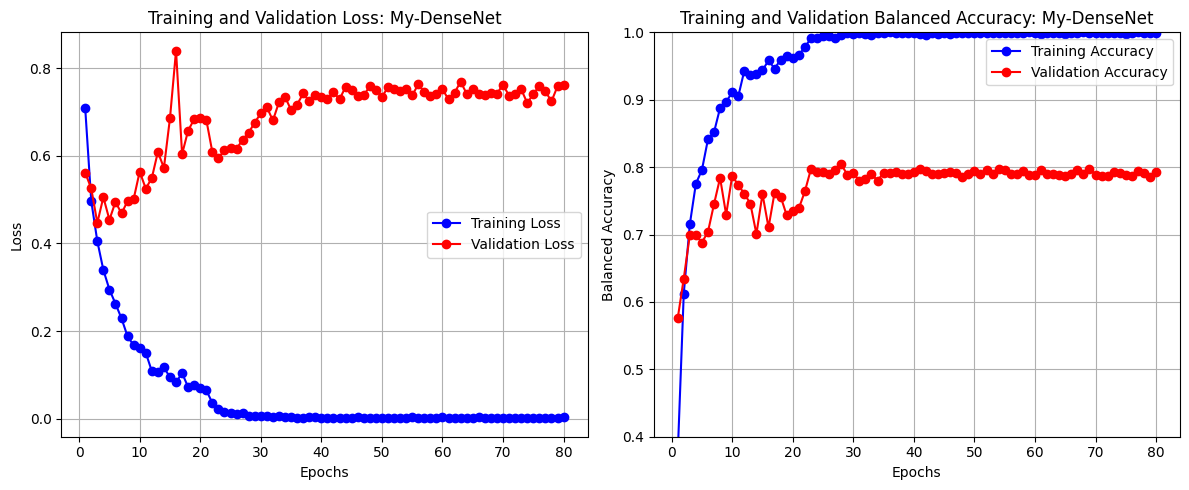

In [22]:
plot_history(densenet_train_loss_hist, densenet_val_loss_hist,
             densenet_train_acc_hist, densenet_val_acc_hist, 'My-DenseNet')

In [23]:
## Seeing the other metrics

print('VGG-16:')
precision, recall, f1, roc_auc = calculate_other_metrics(vgg16_val_predictions, vgg16_val_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

VGG-16:
Weighted Precision: 0.8591, Weighted Recall: 0.8637, Weighted F1: 0.8607, Avg-AUC: 0.8575



In [22]:
print('ResNet50:')
precision, recall, f1, roc_auc = calculate_other_metrics(resnet50_val_predictions, resnet50_val_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

ResNet50:
Weighted Precision: 0.8733, Weighted Recall: 0.8755, Weighted F1: 0.8725, Avg-AUC: 0.8695



In [23]:
print('Densenet:')
precision, recall, f1, roc_auc = calculate_other_metrics(densenet_val_predictions, densenet_val_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}")

Densenet:
Weighted Precision: 0.8845, Weighted Recall: 0.8878, Weighted F1: 0.8838, Avg-AUC: 0.8798


#### The models achieved relatively good results after tunning the hyperparameters, but needing more epochs to converge than the paper cited (the paper stops the training after 30). Also, the learning rate for the DenseNet model was different than the used there (0.001). Instead, using the same value of the other models increased its validation accuracy. Their performances on the validation set shows that the DenseNet is the best model, according to the balanced accuracy obtained (about 78.7%), followed by the ResNet50, with 78% (considering the statistical variation, a draw). The other metrics also reforces this pattern (mainly the average AUC that shows a bigger difference over the models). With the hyperparameters tunned, we now need to test the models over a test set to see how it will perform on a real scenario.

### **4 - Models' Results**

##### **4.1 - Evaluation on Test Data**

In [24]:
## Evaluating the model's performances on the ds_test set

## Vgg16
## Loading model with best accuracy
vgg16.load_state_dict(torch.load('/kaggle/working/models/vgg16_best_balanced_acc.pth'))
vgg16.to(device)

vgg16_test_loss, vgg16_test_accuracy, vgg16_test_balanced_accuracy, vgg16_test_predictions, vgg16_test_labels = evaluate(vgg16, ds_test, criterion, num_classes)

print(f"Test Loss: {vgg16_test_loss:.4f}, Test Accuracy: {vgg16_test_accuracy:.4f}, Test Balanced Accuracy: {vgg16_test_balanced_accuracy:.4f}")

100%|██████████| 35/35 [00:05<00:00,  5.93it/s]

Test Loss: 1.0537, Test Accuracy: 0.8494, Test Balanced Accuracy: 0.7234


In [25]:
## ResNet50
## Loading model with best accuracy
resnet50.load_state_dict(torch.load('/kaggle/working/models/resnet50_best_balanced_acc.pth'))
resnet50.to(device)

resnet50_test_loss, resnet50_test_accuracy, resnet50_test_balanced_accuracy, resnet50_test_predictions, resnet50_test_labels = evaluate(resnet50, ds_test, criterion, num_classes)
print(f"Test Loss: {resnet50_test_loss:.4f}, Test Accuracy: {resnet50_test_accuracy:.4f}, Test Balanced Accuracy: {resnet50_test_balanced_accuracy:.4f}")

100%|██████████| 35/35 [00:03<00:00,  9.26it/s]

Test Loss: 0.6856, Test Accuracy: 0.8503, Test Balanced Accuracy: 0.7120


In [26]:
## DenseNet
## Loading model with best accuracy
densenet.load_state_dict(torch.load('/kaggle/working/models/densenet_best_balanced_acc.pth'))
densenet.to(device)

densenet_test_loss, densenet_test_accuracy, densenet_test_balanced_accuracy, densenet_test_predictions, densenet_test_labels = evaluate(densenet, ds_test, criterion, num_classes)
print(f"Test Loss: {densenet_test_loss:.4f}, Test Accuracy: {densenet_test_accuracy:.4f}, Test Balanced Accuracy: {densenet_test_balanced_accuracy:.4f}")

100%|██████████| 35/35 [00:04<00:00,  8.61it/s]

Test Loss: 0.6303, Test Accuracy: 0.8793, Test Balanced Accuracy: 0.8052


#### The test set performance for all models drops a little, but the results still consistent with the DenseNet taking the lead of the balanced accuracy performance.

#### Obs: the results on the test set is a little bit better than the validation set for the DenseNet model, but it can be easily explained by the samples of the test set being easier to classify, the set being smaller or just luck (statistical variation).

##### **4.2 - Confusion Matrix of the Models and other Metrics**

In [27]:
## Label for the numerical targets

unique_pairs = df_test.drop_duplicates(subset=['cell_type', 'cell_type_idx'])

unique_pairs[['cell_type', 'cell_type_idx']].sort_values(by='cell_type_idx').reset_index(drop=True)

cell_type  cell_type_idx
0               Actinic keratoses              0
1            Basal cell carcinoma              1
2  Benign keratosis-like lesions               2
3                  Dermatofibroma              3
4                Melanocytic nevi              4
5                        Melanoma              5
6                Vascular lesions              6

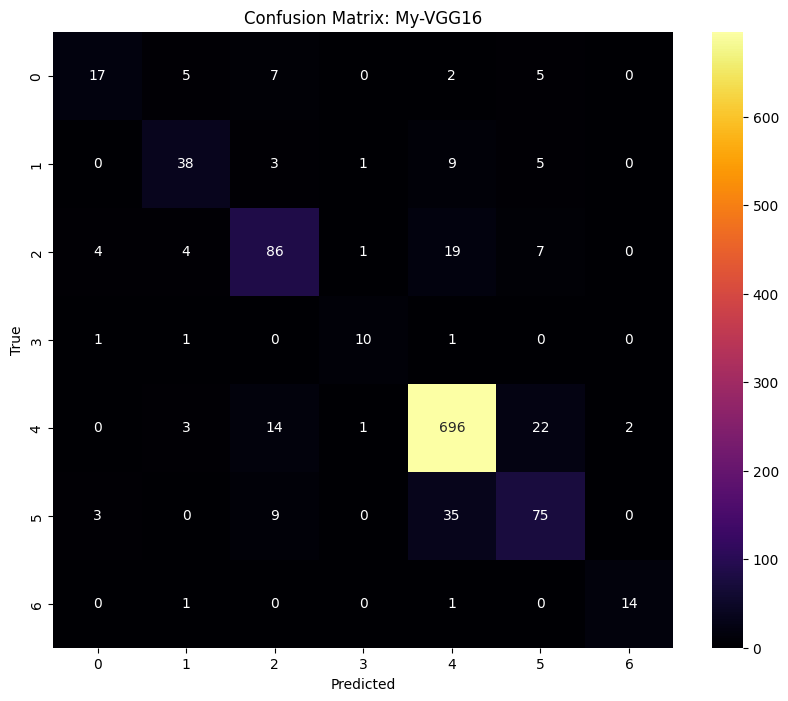

In [28]:
## VGG16

plot_confusion_matrix(vgg16_test_predictions, vgg16_test_labels, num_classes, 'My-VGG16')

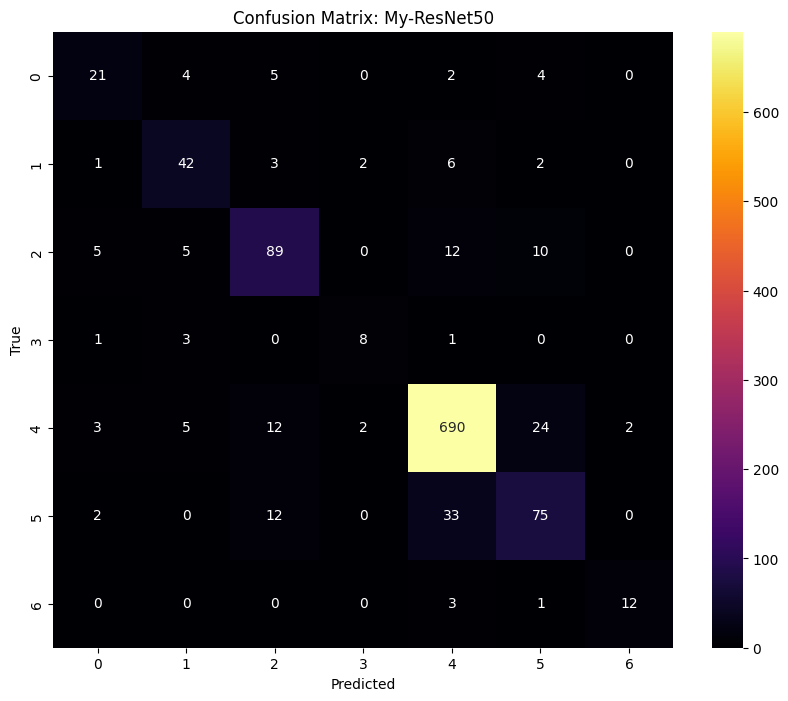

In [29]:
## ResNet50

plot_confusion_matrix(resnet50_test_predictions, resnet50_test_labels, num_classes, 'My-ResNet50')

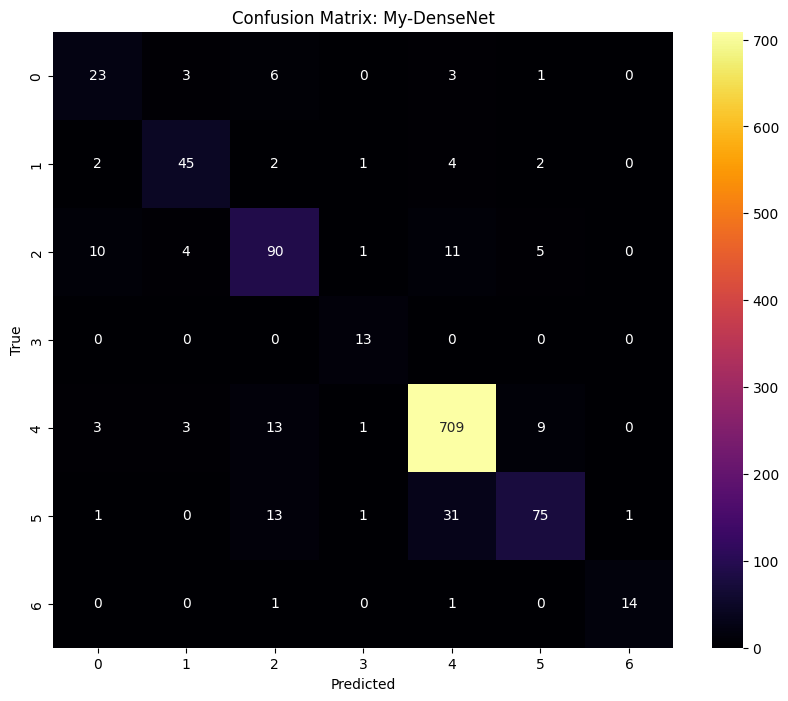

In [30]:
## DenseNet

plot_confusion_matrix(densenet_test_predictions, densenet_test_labels, num_classes, 'My-DenseNet')

In [31]:
## Seeing the other metrics

print('VGG-16:')

precision, recall, f1, roc_auc = calculate_other_metrics(vgg16_test_predictions, vgg16_test_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

print('ResNet50:')
precision, recall, f1, roc_auc = calculate_other_metrics(resnet50_test_predictions, resnet50_test_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

print('Densenet:')
precision, recall, f1, roc_auc = calculate_other_metrics(densenet_test_predictions, densenet_test_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}")

VGG-16:
Weighted Precision: 0.8442, Weighted Recall: 0.8494, Weighted F1: 0.8459, Avg-AUC: 0.8415

ResNet50:
Weighted Precision: 0.8482, Weighted Recall: 0.8503, Weighted F1: 0.8490, Avg-AUC: 0.8371

Densenet:
Weighted Precision: 0.8783, Weighted Recall: 0.8793, Weighted F1: 0.8769, Avg-AUC: 0.8869


#### The metrics and the graphs show that, for the main and the auxiliary metrics suggested by the referred paper, all 3 models got pretty good results, being able to achieve values above 70% for all metrics. Nevertheless, those metrics are inflated, not ideal for cases of data with unbalanced classes. With this in mind, an approach taking into account metrics such as balanced accuracy and normalized accuracy is necessary, adjusting the hyperparameters in order to maximize performance in these new metrics. By optimizing the models according to this metric, we achieved slightly lower values, but this time with more reliability, with the best model being the DenseNet.

### **5 - Distribuition Shift**

##### **5.1 - Loading the Out of Distribution (OOD) Data: PAD-UFES-20**

In [32]:
## Loading the PAD-UFES-20 data

pad_ufes_lesion_type_dict = {
    'NEV': 'Nevus',
    'MEL': 'Melanoma',
    'SEK': 'Seborrheic Keratosis',
    'SCC': 'Squamous Cell Carcinoma',
    'BCC': 'Basal cell carcinoma',
    'ACK': 'Actinic keratoses',
    'BKL': 'Benign keratosis-like lesions', ## no samples
    'DF': 'Dermatofibroma', ## no samples
    'VASC': 'Vascular lesions' ## no samples
}


# (matching the encoding of the HAM10K)
ordinal_mapping = {
    'NEV': 4, 'BCC': 1, 'ACK': 0, 'SEK': 7, 'SCC': 8, 'MEL': 5, 'BKL': 2, 'DF': 3, 'VASC': 6 
}

## reading dataframe

pad_ufes_df = pd.read_csv('/kaggle/input/pad-ufes-20/PAD-UFES-20/PAD-UFES-20_Dataset_GroundTruth.csv')
pad_ufes_df['labels'] = pad_ufes_df['diagnostic'].map(ordinal_mapping)
pad_ufes_df['cell_type'] = pad_ufes_df['diagnostic'].map(pad_ufes_lesion_type_dict)



## Adding the path of each image of the referred folder to a column called path
pad_ufes_df['path'] = pad_ufes_df['img_id'].apply(lambda x: f'/kaggle/input/pad-ufes-20/PAD-UFES-20/images/{x}')

pad_ufes_df

patient_id  lesion_id  smoke  drink background_father background_mother  \
0      PAT_1516       1765    NaN    NaN               NaN               NaN   
1        PAT_46        881  False  False         POMERANIA         POMERANIA   
2      PAT_1545       1867    NaN    NaN               NaN               NaN   
3      PAT_1989       4061    NaN    NaN               NaN               NaN   
4       PAT_684       1302  False   True         POMERANIA         POMERANIA   
...         ...        ...    ...    ...               ...               ...   
2293   PAT_1708       3156    NaN    NaN               NaN               NaN   
2294     PAT_46        880  False  False         POMERANIA         POMERANIA   
2295   PAT_1343       1217    NaN    NaN               NaN               NaN   
2296    PAT_326        690  False  False         POMERANIA         POMERANIA   
2297   PAT_1714       3189    NaN    NaN               NaN               NaN   

      age pesticide  gender skin_cancer_history  ...   grew   hurt changed  \
0       8       NaN     NaN                 NaN  ...  False  False   False   
1      55     False  FEMALE                True  ...   True  False    True   
2      77       NaN     NaN                 NaN  ...  False  False   False   
3      75       NaN     NaN                 NaN  ...  False  False   False   
4      79     False    MALE                True  ...   True  False   False   
...   ...       ...     ...                 ...  ...    ...    ...     ...   
2293   73       NaN     NaN                 NaN  ...  False  False   False   
2294   55     False  FEMALE                True  ...   True  False    True   
2295   74       NaN     NaN                 NaN  ...  False  False   False   
2296   58      True  FEMALE                True  ...  False  False   False   
2297   41       NaN     NaN                 NaN  ...   True  False   False   

      bleed elevation                 img_id  biopsed labels  \
0     False     False  PAT_1516_1765_530.png    False      4   
1      True      True     PAT_46_881_939.png     True      1   
2     False     False  PAT_1545_1867_547.png    False      0   
3     False     False  PAT_1989_4061_934.png    False      0   
4      True      True   PAT_684_1302_588.png     True      1   
...     ...       ...                    ...      ...    ...   
2293  False     False  PAT_1708_3156_175.png    False      0   
2294  False     False     PAT_46_880_140.png     True      1   
2295  False     False  PAT_1343_1217_404.png    False      7   
2296  False      True    PAT_326_690_823.png     True      1   
2297  False      True  PAT_1714_3189_989.png    False      7   

                 cell_type                                               path  
0                    Nevus  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
1     Basal cell carcinoma  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
2        Actinic keratoses  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
3        Actinic keratoses  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
4     Basal cell carcinoma  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
...                    ...                                                ...  
2293     Actinic keratoses  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
2294  Basal cell carcinoma  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
2295  Seborrheic Keratosis  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
2296  Basal cell carcinoma  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  
2297  Seborrheic Keratosis  /kaggle/input/pad-ufes-20/PAD-UFES-20/images/P...  

[2298 rows x 29 columns]

##### **5.2 - Data Cleaning and EDA**

In [33]:
#Removing the classes that aren't present on the ID data of the OOD dataset

pad_ufes_test = pad_ufes_df[pad_ufes_df['labels'] <= 6]

print(len(pad_ufes_test)) ## only 1871 samples left


1871


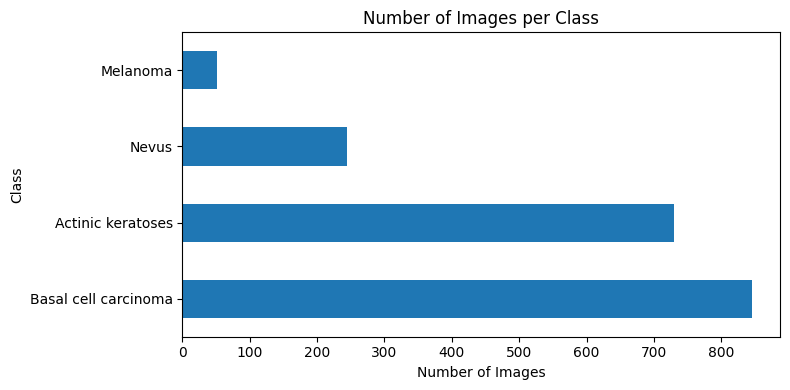

cell_type
Basal cell carcinoma    845
Actinic keratoses       730
Nevus                   244
Melanoma                 52
Name: count, dtype: int64


In [34]:
# Count the number of images in each class
class_counts = pad_ufes_test['cell_type'].value_counts()

# Plot a histogram
plt.figure(figsize=(8, 4))
class_counts.plot(kind='barh')

# Add title and labels
plt.title('Number of Images per Class')
plt.ylabel('Class')
plt.xlabel('Number of Images')

# Display the plot
plt.tight_layout()
plt.show()


print(class_counts)

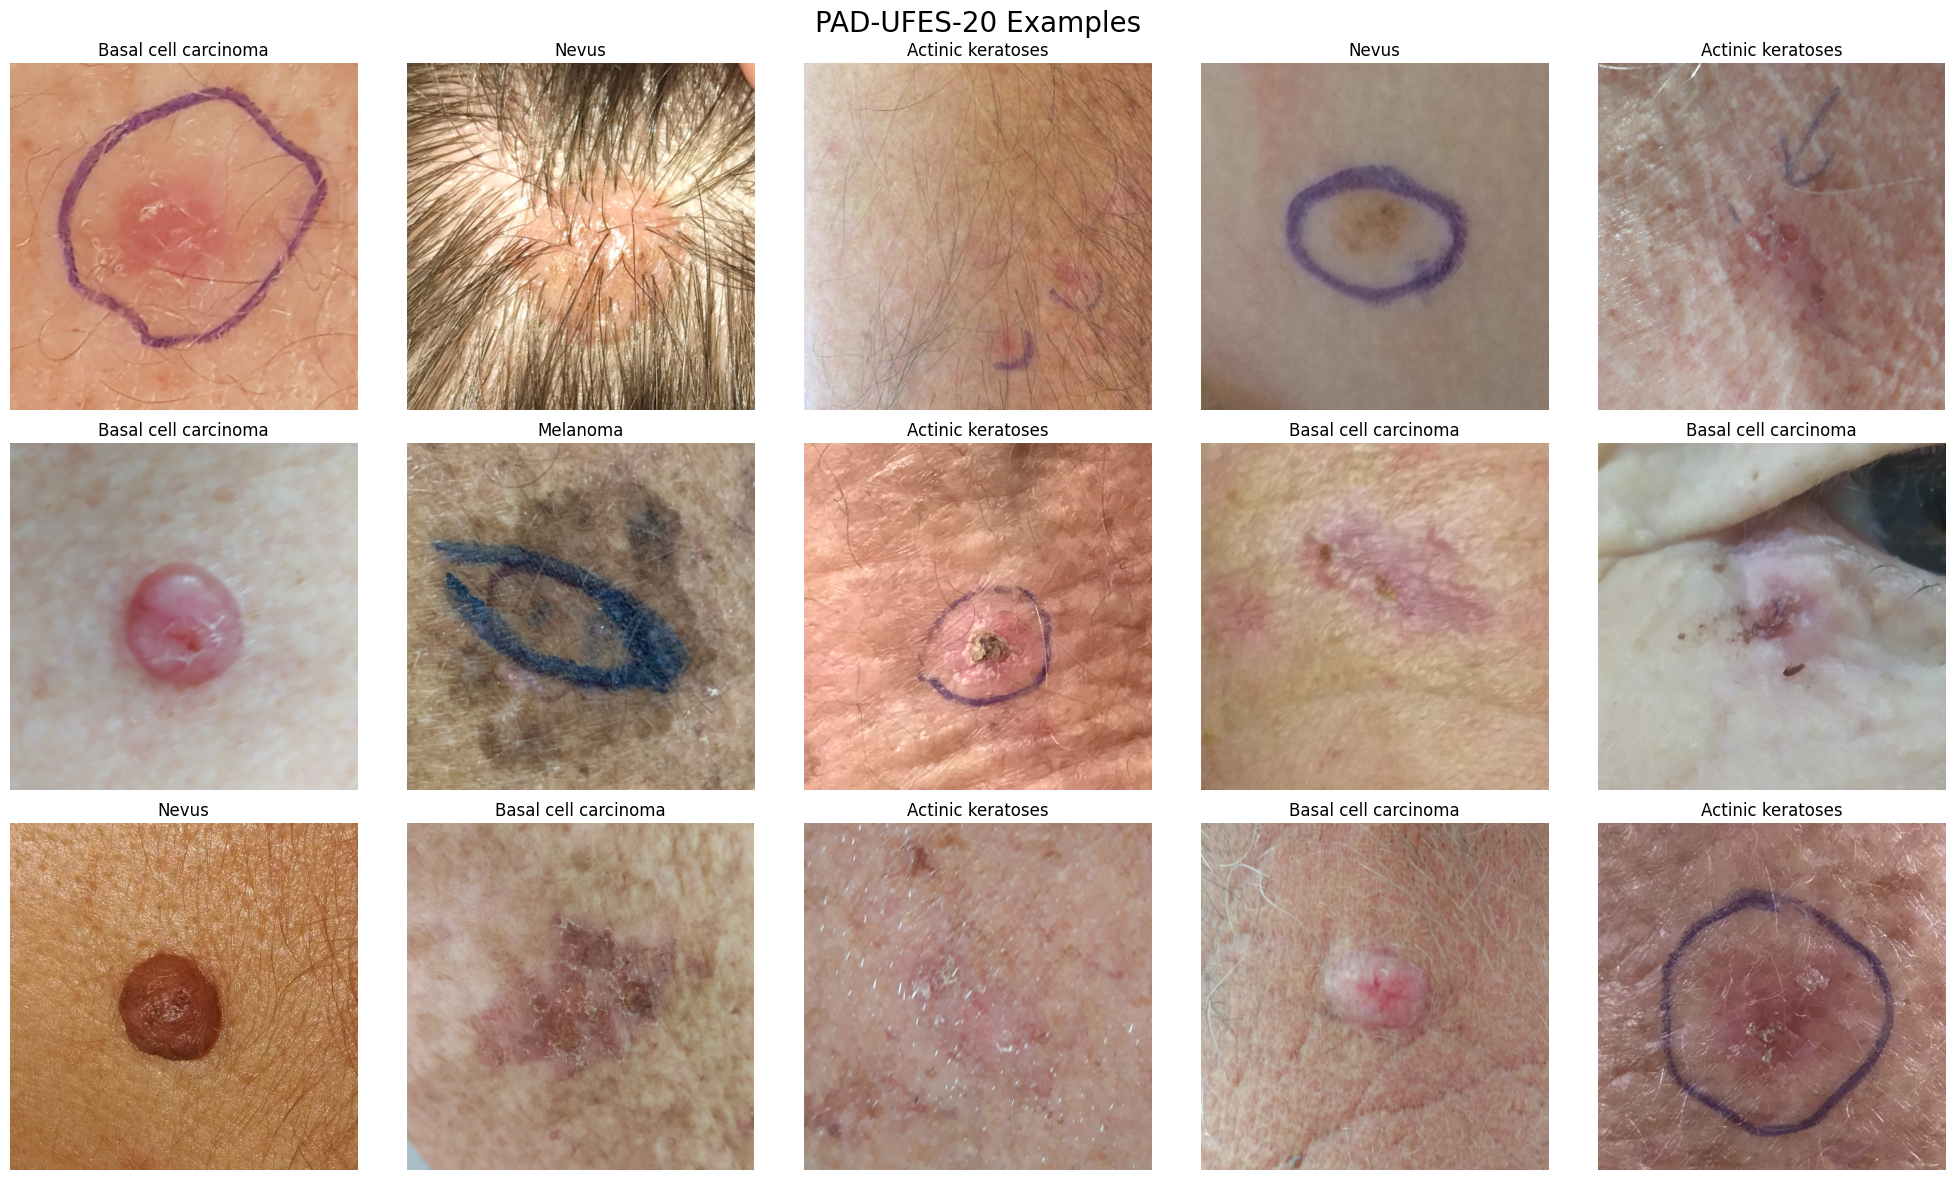

CPU times: user 5.46 s, sys: 299 ms, total: 5.75 s
Wall time: 5.86 s


In [35]:
%%time
## Showing some examples of the data

# Randomly select 15 rows from the dataframe
sample_df = pad_ufes_test.sample(n=15)

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = row['path']
    cell_type = row['cell_type']
    
    # Open the image
    img = Image.open(img_path)
    
    # Display the image on the axis
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')  # Hide the axes ticks

# Add a main title for the whole plot
plt.suptitle('PAD-UFES-20 Examples', fontsize=20)
# Adjust the layout
plt.tight_layout()
plt.show()

#### The images are quite different, captured with smartphone's cameras.

##### **5.3 - Creating the Dataset**

In [36]:
## Function to load the Dataset

class CustomPAD_UFES_20(Dataset):
    def __init__(self, dataframe, img_size, transform=None):
        self.paths = dataframe['path'].values
        self.labels = torch.tensor(dataframe['labels'].values, dtype=torch.long)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert("RGB")  # converts to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    

test_pad_ufes20data = CustomPAD_UFES_20(pad_ufes_test, img_size, transform=transform_val) ## same transformations than the train data
ds_pad_ufes20_test = DataLoader(test_pad_ufes20data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) ## not shuffle (same sample order always)

##### **5.4 - Evaluating the Models' Performance under Distribution Shift and Selective Classification**

In [37]:
## Loading the models

models = [vgg16, resnet50, densenet]


In [38]:
## Vgg16

models[0].to(device)

vgg16_ood_loss, vgg16_ood_accuracy, vgg16_ood_balanced_accuracy, vgg16_ood_predictions, vgg16_ood_labels = evaluate(models[0], ds_pad_ufes20_test, criterion, num_classes)

print(f"Test OOD Loss: {vgg16_ood_loss:.4f}, Test OOD Accuracy: {vgg16_ood_accuracy:.4f}, Test OOD Balanced Accuracy: {vgg16_ood_balanced_accuracy:.4f}")

100%|██████████| 59/59 [00:37<00:00,  1.57it/s]

Test OOD Loss: 6.7961, Test OOD Accuracy: 0.2806, Test OOD Balanced Accuracy: 0.3219



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [39]:
## ResNet50
models[1].to(device)

resnet50_ood_loss, resnet50_ood_accuracy, resnet50_ood_balanced_accuracy, resnet50_ood_predictions, resnet50_ood_labels = evaluate(models[1], ds_pad_ufes20_test, criterion, num_classes)

print(f"Test OOD Loss: {resnet50_ood_loss:.4f}, Test OOD Accuracy: {resnet50_ood_accuracy:.4f}, Test OOD Balanced Accuracy: {resnet50_ood_balanced_accuracy:.4f}")

100%|██████████| 59/59 [00:30<00:00,  1.96it/s]

Test OOD Loss: 4.4284, Test OOD Accuracy: 0.2715, Test OOD Balanced Accuracy: 0.3363



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [40]:
## DenseNet
models[2].to(device)
densenet_ood_loss, densenet_ood_accuracy, densenet_ood_balanced_accuracy, densenet_ood_predictions, densenet_ood_labels = evaluate(models[2], ds_pad_ufes20_test, criterion, num_classes)

print(f"Test OOD Loss: {densenet_ood_loss:.4f}, Test OOD Accuracy: {densenet_ood_accuracy:.4f}, Test OOD Balanced Accuracy: {densenet_ood_balanced_accuracy:.4f}")

100%|██████████| 59/59 [00:30<00:00,  1.93it/s]

Test OOD Loss: 4.3676, Test OOD Accuracy: 0.3191, Test OOD Balanced Accuracy: 0.3461



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


#### As expected the performance for all models dropped drastically, but this can be solved, without training, using selective classification. By ranking the samples by its MSP (Maximum Softmax Probability) values, we can see how the risk increases as we cover more parts of the data (decreasing the threshold for accept a given prediction) and select a point of operation to maintain a certain level of performance given coverage of the data.



#### First, we need to define some functions to help to plot the Risk x Coverage curve.

In [41]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
  

def get_unique_labels(data_loader):
    """Get unique labels from the dataset."""
    unique_labels = set()
    for _, label in data_loader:
        unique_labels.update(label.numpy())
    return sorted(list(unique_labels))

def accumulate_results(model, data_loader, set_eval=True):
    '''Accumulate output (of model) and label of an entire dataset.'''

    # Get unique labels from the dataset
    #valid_classes = get_unique_labels(data_loader)
    
    dev = next(model.parameters()).device
    dtype = next(model.parameters()).dtype
    if set_eval:
        model.eval()

    output_list = []
    label_list = []
    with torch.no_grad():
        for image, label in data_loader:
            image, label = image.to(dev, dtype), label.to(dev)
            label_list.append(label)
            logits = model(image)
            
            # Filter logits for valid classes only
            #logits_filtered = logits[: , valid_classes]
            
            # Apply softmax to renormalize probabilities
            probabilities = F.softmax(logits, dim=1)
            
            output_list.append(probabilities)

    output_list = torch.cat(output_list)
    label_list = torch.cat(label_list)
    
    return output_list, label_list

def compute_confidence(probabilities):
    """Compute the MSP confidence score for each prediction."""
    return torch.max(probabilities, dim=1).values ## max value of dim 1 (max class of sample)

# Function to calculate Risk Coverage Curve
def compute_risk_coverage(probabilities, labels, metric):
    """Compute risk and coverage for different thresholds."""
    confidence = compute_confidence(probabilities)
    sorted_confidence, sorted_indices = torch.sort(confidence, descending=True)
    sorted_labels = labels[sorted_indices]
    sorted_preds = torch.argmax(probabilities[sorted_indices], dim=1)
    
    full_coverage = len(labels)
    cov_init = 1
    
    risks = []
    
    if metric == 'acc':
        
        ideal_risks = []
        
        # Create mask where sorted_labels are equal to sorted_preds
        equal_mask = sorted_labels == sorted_preds

        # Separate equal and unequal elements
        equal_labels = sorted_labels[equal_mask]
        unequal_labels = sorted_labels[~equal_mask]
        equal_preds = sorted_preds[equal_mask]
        unequal_preds = sorted_preds[~equal_mask]

        # Concatenate equal elements at the beginning and unequal elements afterwards
        ideal_sorted_labels = torch.cat((equal_labels, unequal_labels), dim=0)
        ideal_sorted_preds = torch.cat((equal_preds, unequal_preds), dim=0)
    
    
    for i in tqdm(range(full_coverage)):
        # risk x num de logits 
        selected_labels = sorted_labels[:cov_init]
        selected_preds = sorted_preds[:cov_init]
        
        if metric == 'acc':
            chosen_acc = accuracy_score(selected_labels.cpu().numpy(), selected_preds.cpu().numpy())
            
            ide_selected_labels = ideal_sorted_labels[:cov_init]
            ide_selected_preds = ideal_sorted_preds[:cov_init]
            
            ide_acc = accuracy_score(ide_selected_labels.cpu().numpy(), ide_selected_preds.cpu().numpy())
            
            ideal_risks.append((1-ide_acc))
            
        else:
            chosen_acc = balanced_accuracy_score(selected_labels.cpu().numpy(), selected_preds.cpu().numpy())
            
        risk = 1 - chosen_acc
        risks.append(risk)
        cov_init+=1
    
    if metric == 'acc':
        return risks, ideal_risks
    else:
        return risks

#### Now we plot the RC curve to each model.

100%|██████████| 1871/1871 [00:01<00:00, 1096.60it/s]


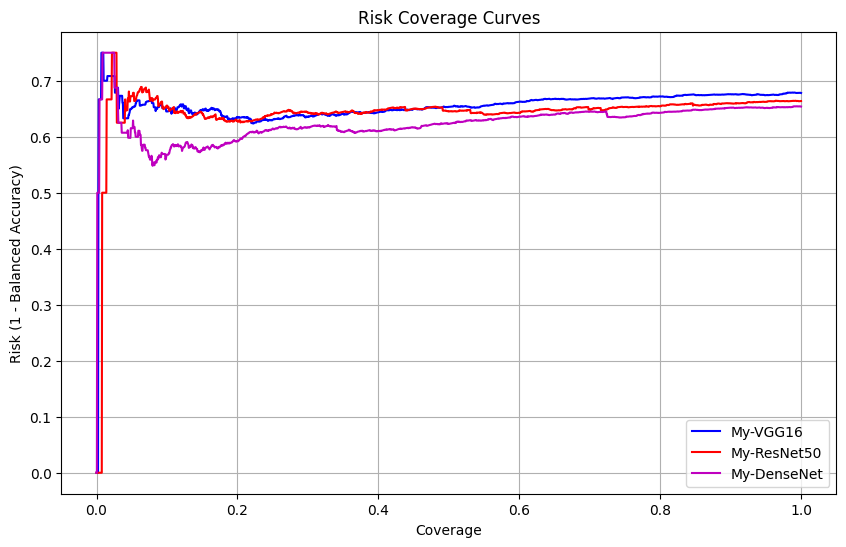

100%|██████████| 1871/1871 [00:01<00:00, 1002.83it/s]


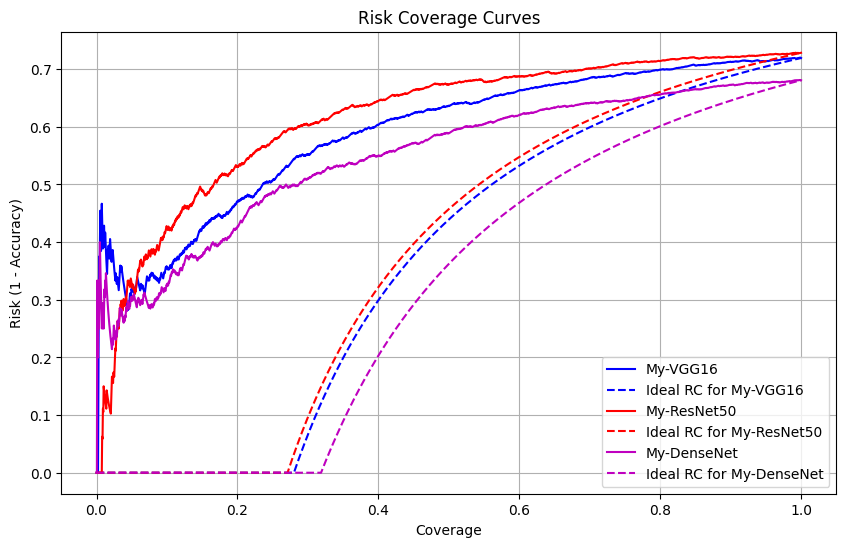

CPU times: user 20.5 s, sys: 1.78 s, total: 22.3 s
Wall time: 3min 12s


In [42]:
%%time
## Plotting the RC curves for each model
import warnings
# Suppress the specific sklearn warning
warnings.filterwarnings("ignore", message= "y_pred contains classes not in y_true")

models_names = ['My-VGG16', 'My-ResNet50', 'My-DenseNet']
#thresholds = np.linspace(0, 1.0, 100)

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    model.to(device)
    outputs, labels = accumulate_results(model, ds_pad_ufes20_test, set_eval=True)
    
    risks = compute_risk_coverage(outputs, labels, 'balanced_acc')

    # Plot Risk Coverage curve for each model
    x = np.linspace(0, 1, len(risks))
    plt.plot(x, risks, label=models_names[i], color=colors[i])

plt.xlabel('Coverage')
plt.ylabel('Risk (1 - Balanced Accuracy)')
plt.title('Risk Coverage Curves')
plt.grid()
plt.legend()
plt.show()


colors = ['b', 'r', 'm']

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    model.to(device)
    outputs, labels = accumulate_results(model, ds_pad_ufes20_test, set_eval=True)
    
    risks, ideal = compute_risk_coverage(outputs, labels, 'acc')

    # Plot Risk Coverage curve for each model
    x = np.linspace(0, 1, len(risks))
    plt.plot(x, risks, label=models_names[i], color=colors[i])
    plt.plot(x, ideal, label=f'Ideal RC for {models_names[i]}', linestyle='--', color=colors[i])

plt.xlabel('Coverage')
plt.ylabel('Risk (1 - Accuracy)')
plt.title('Risk Coverage Curves')
plt.grid()
plt.legend()
plt.show()




#### Those curves shows amount of data that the models are capable of make predictions over (coverage) with a risk associated, so, similar to the ROC curve, usually an operating point is chosen for certains applications. The AURC (area under the RC curve) is a metric widely used to quantify how good a model is for selective classification. The lower the AURC, the better.

#### Given the previous results of the models on the PAD-UFES-20 data, focusing on the balanced accuracy and the standard accuracy, the RC curves for both metrics just shows that the risk increase fast due to the low confidence of the 3 models over this OOD data. 